/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:28: UserWarning: Module Box2D not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:28: UserWarning: Module py4j not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/glfw/__init__.py:916: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)
/home/ramans/miniconda3/envs/c_mbrl/lib/python3.9/site-packages/carl/envs/__init__.py:28: UserWarning: Module distance not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(


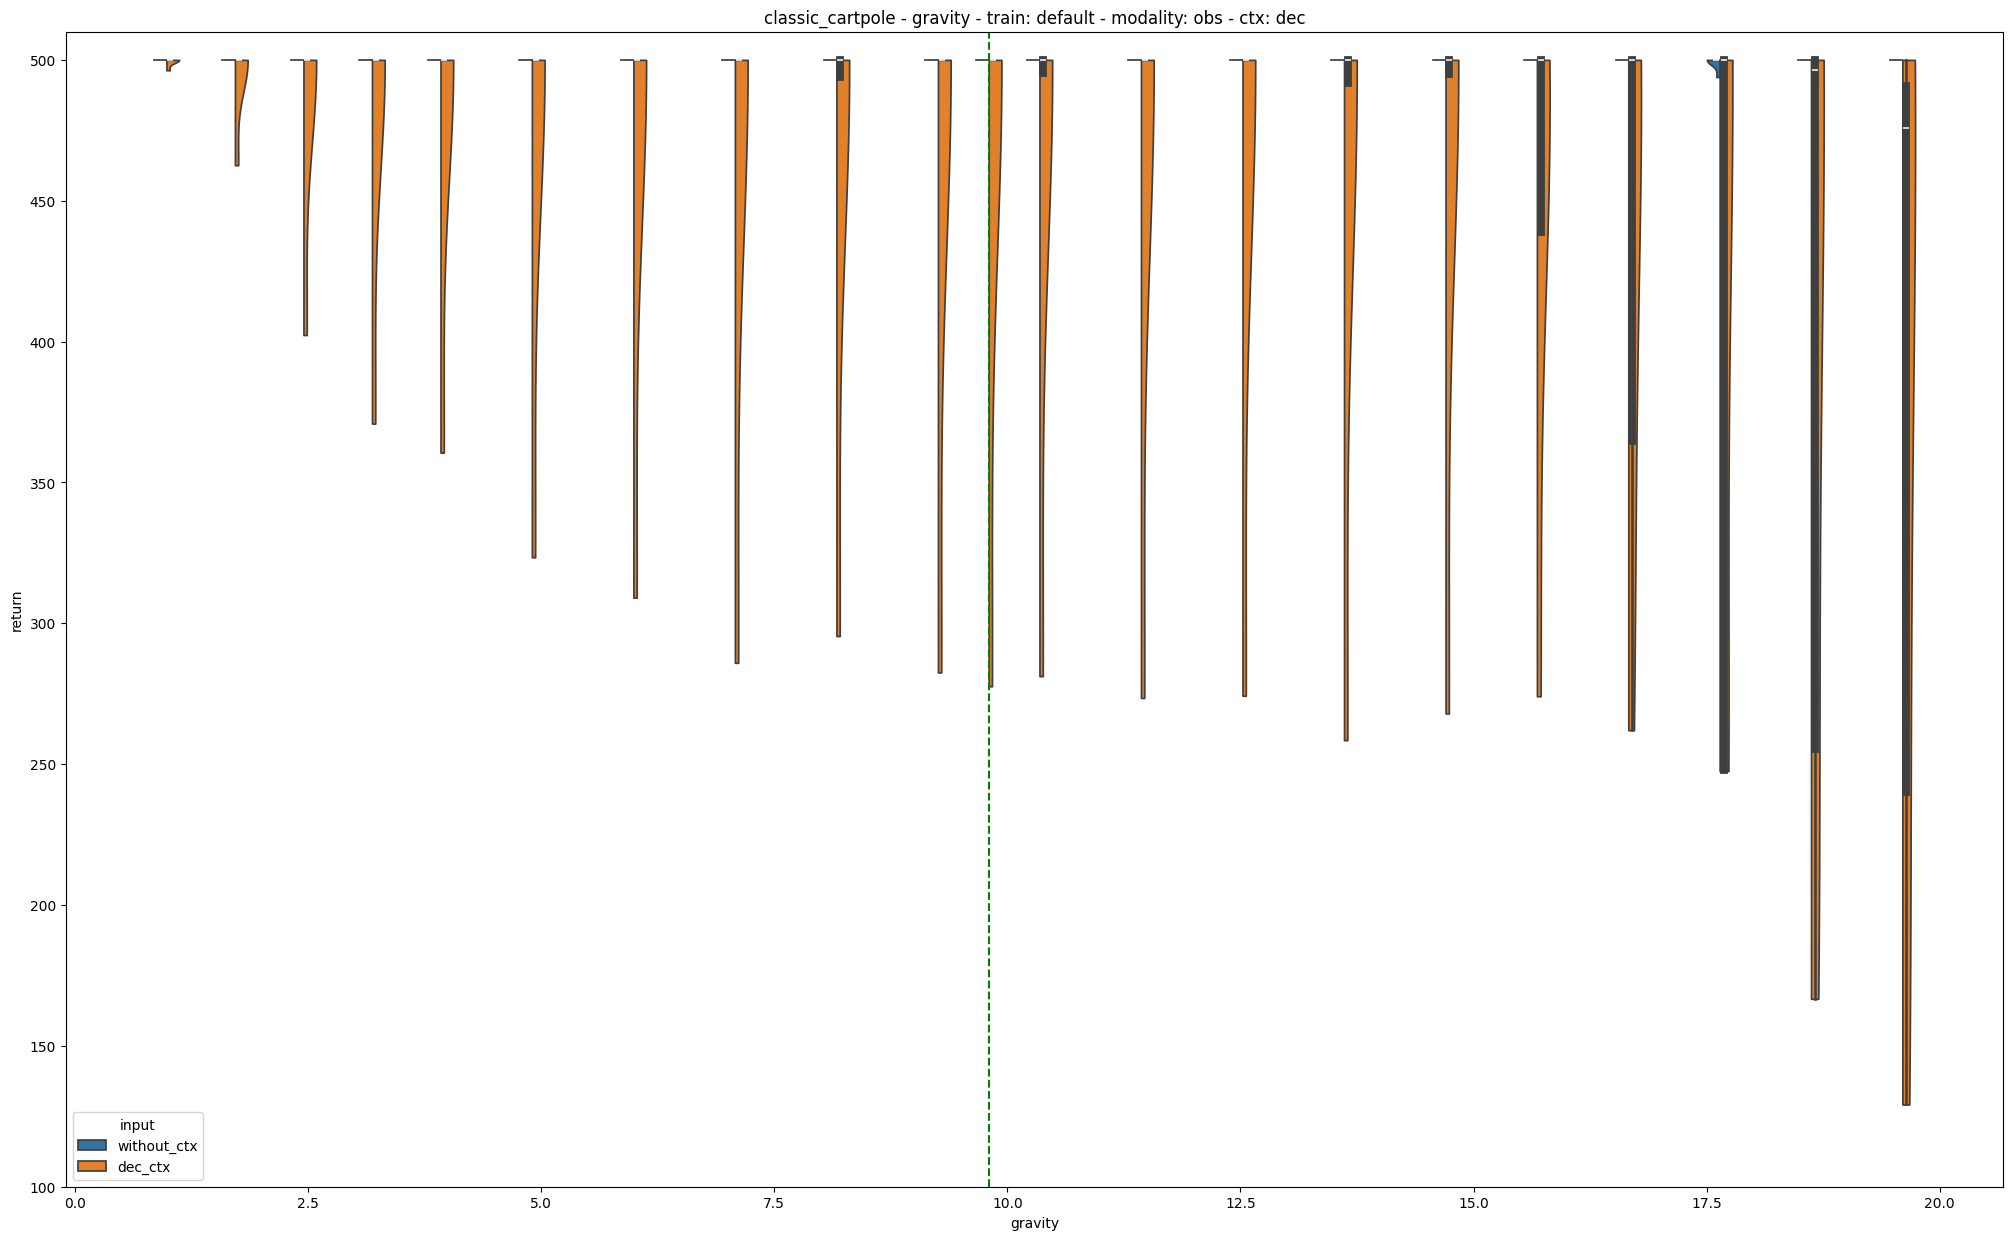

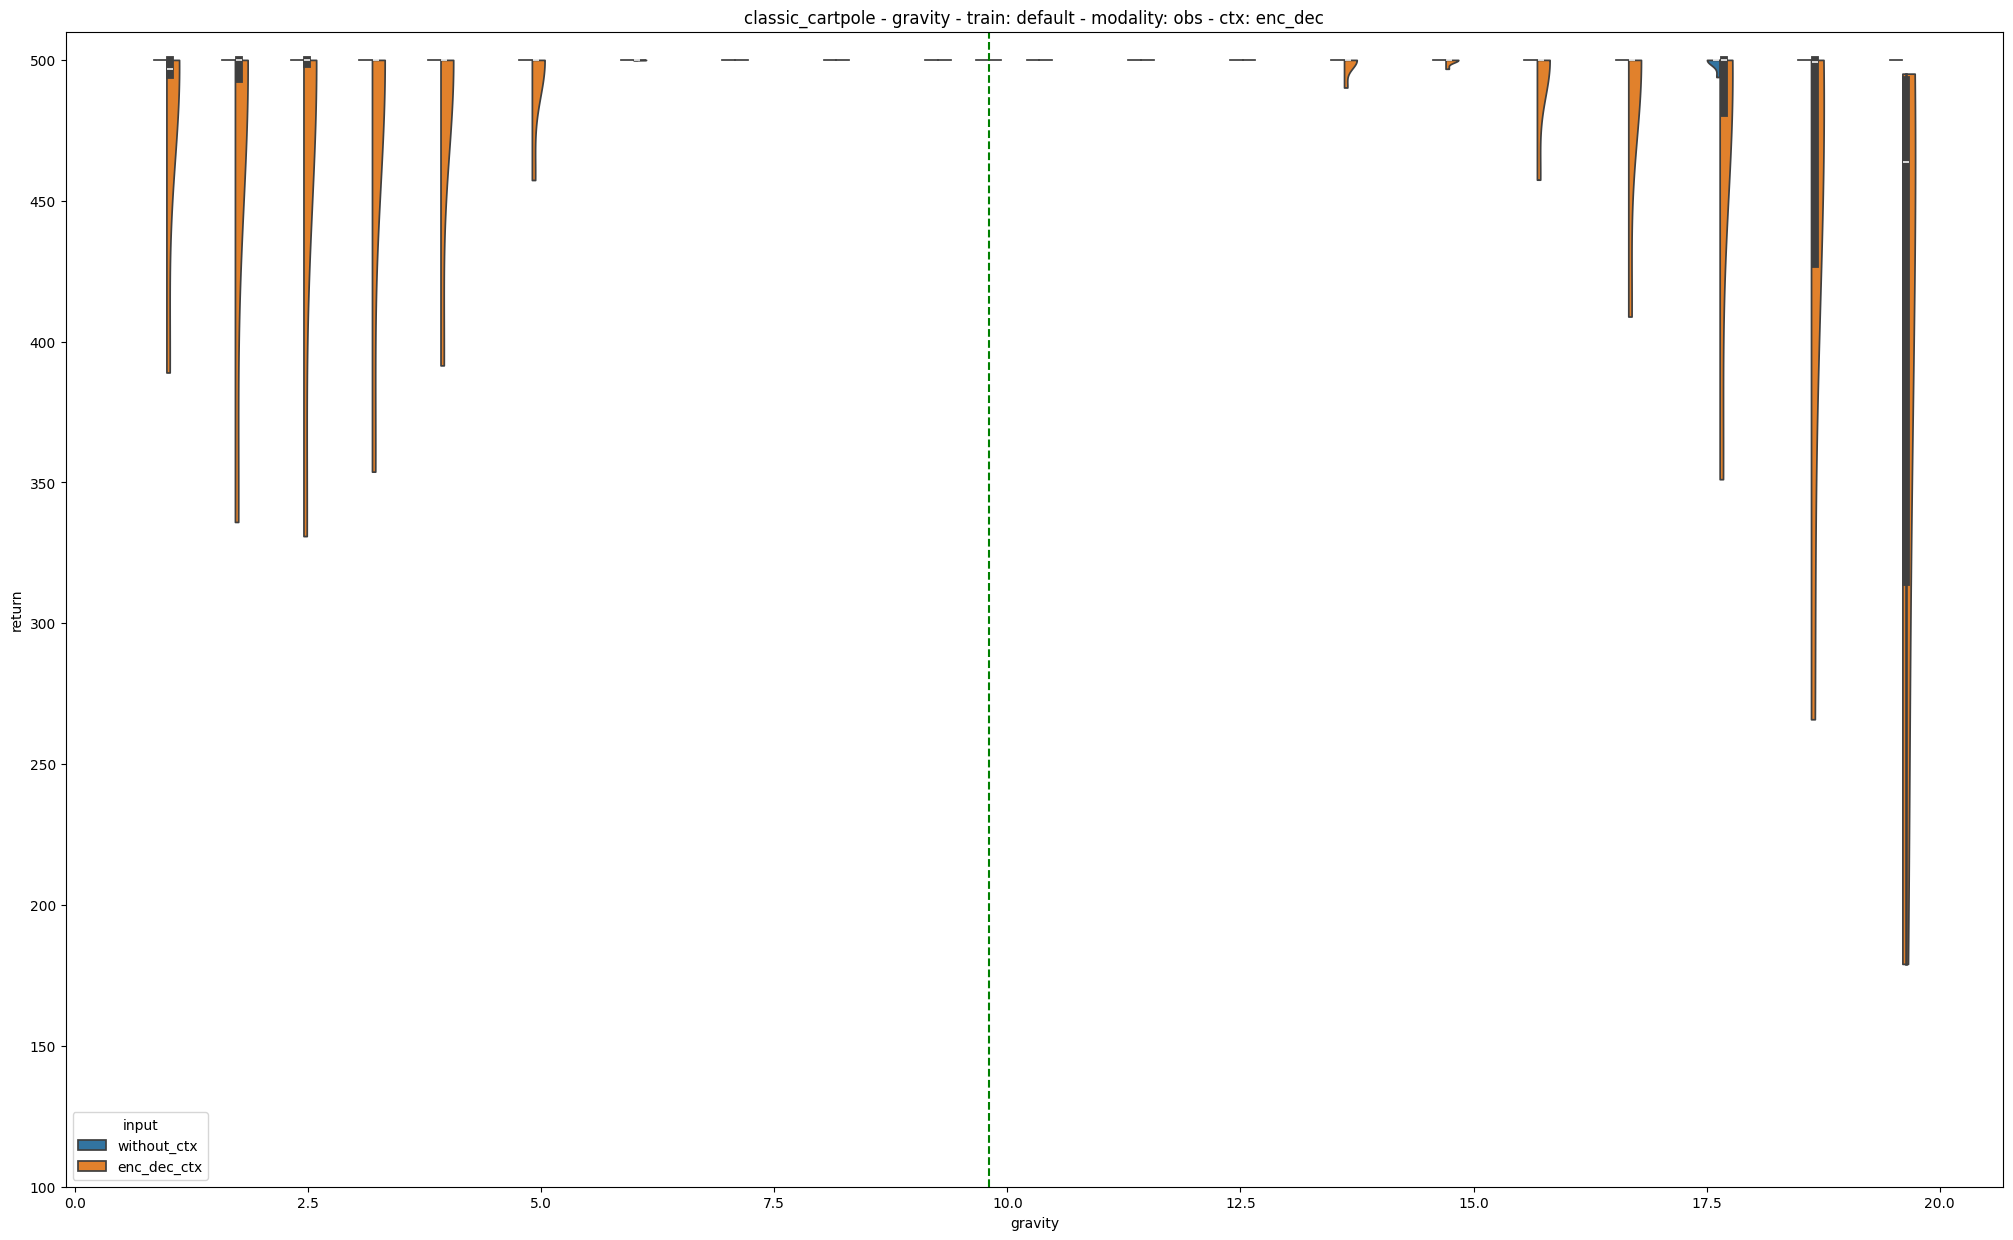

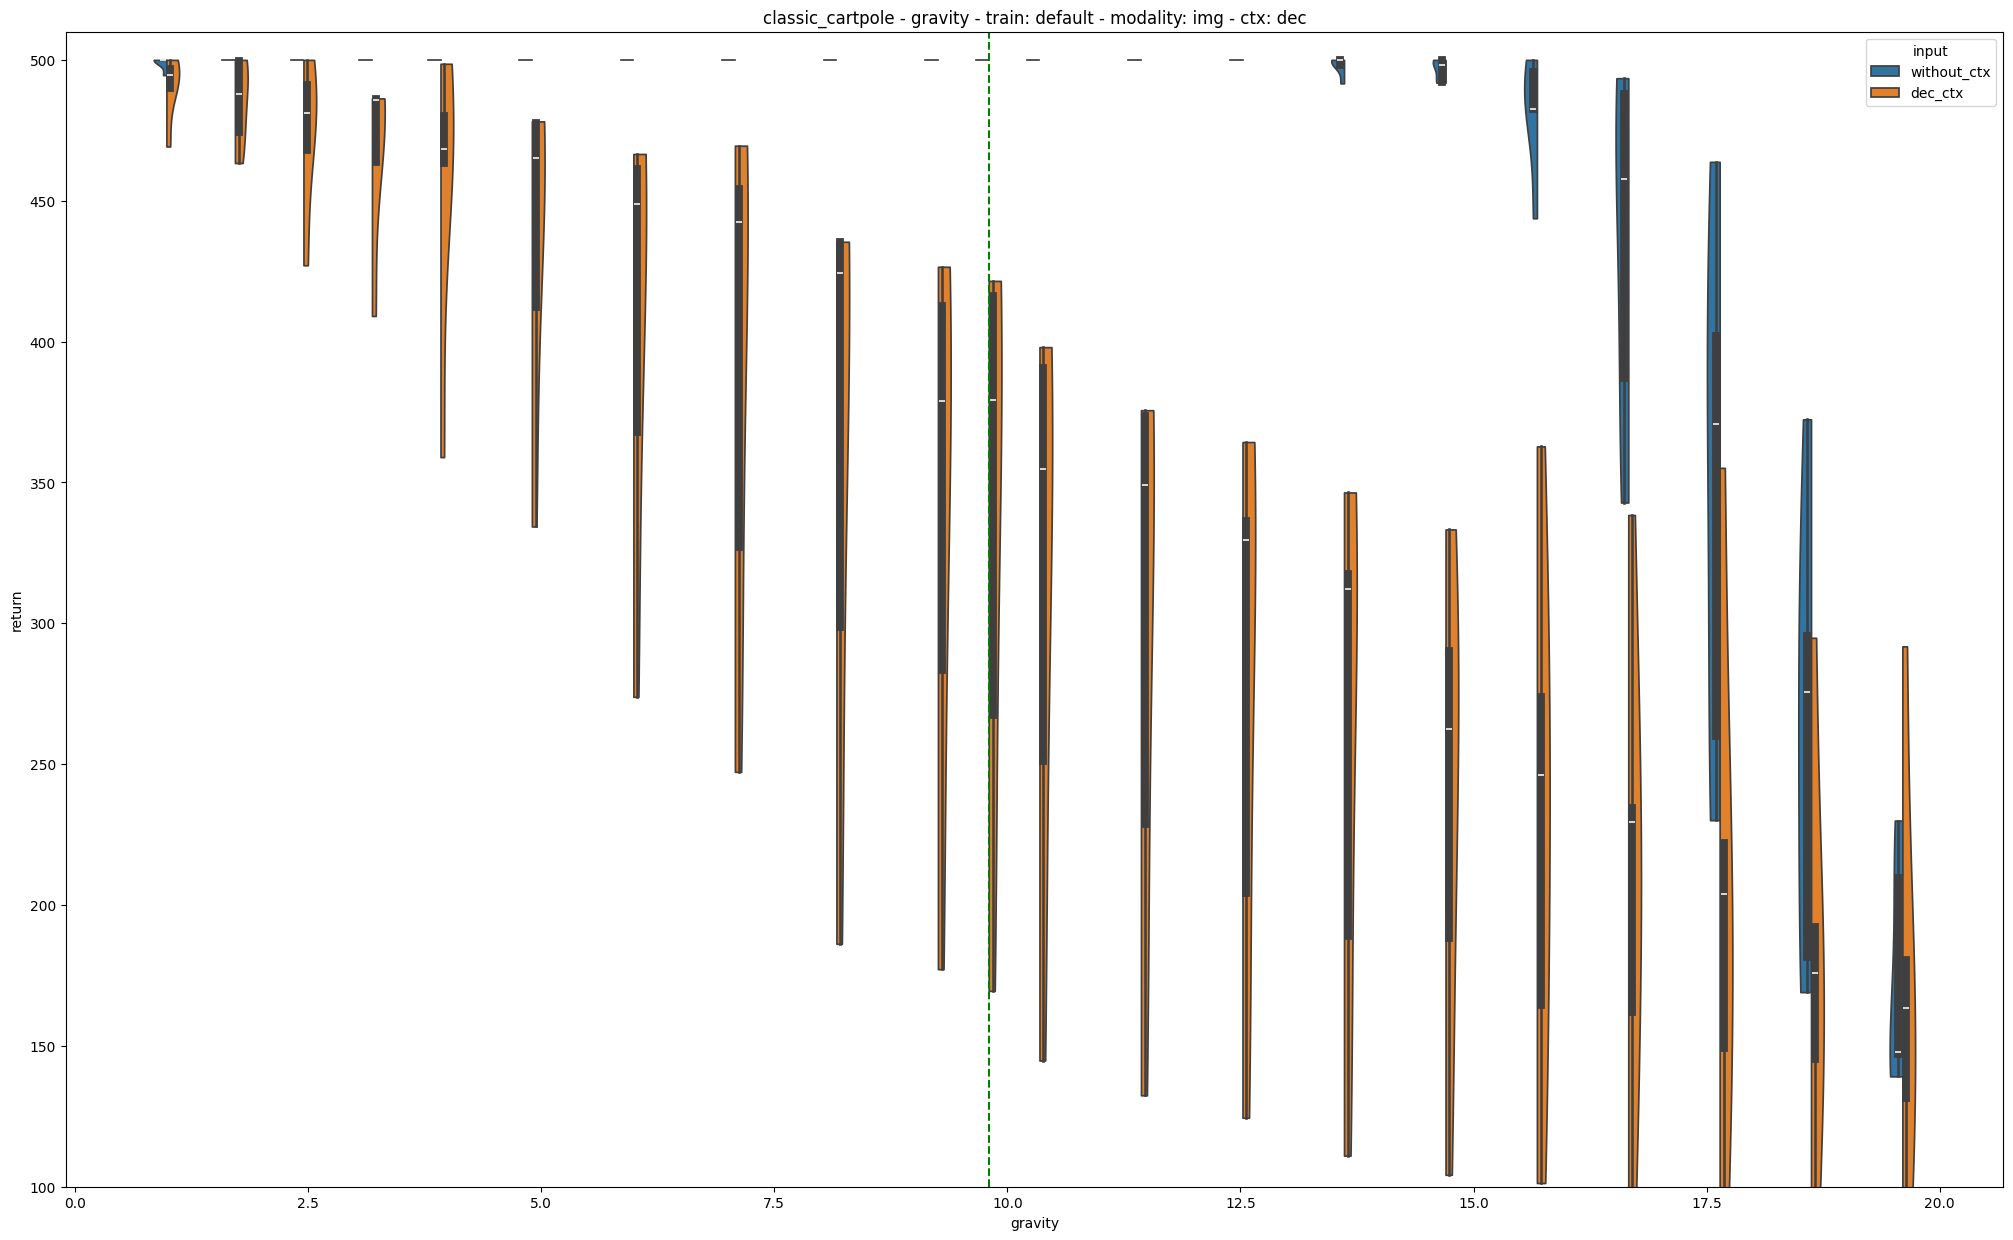

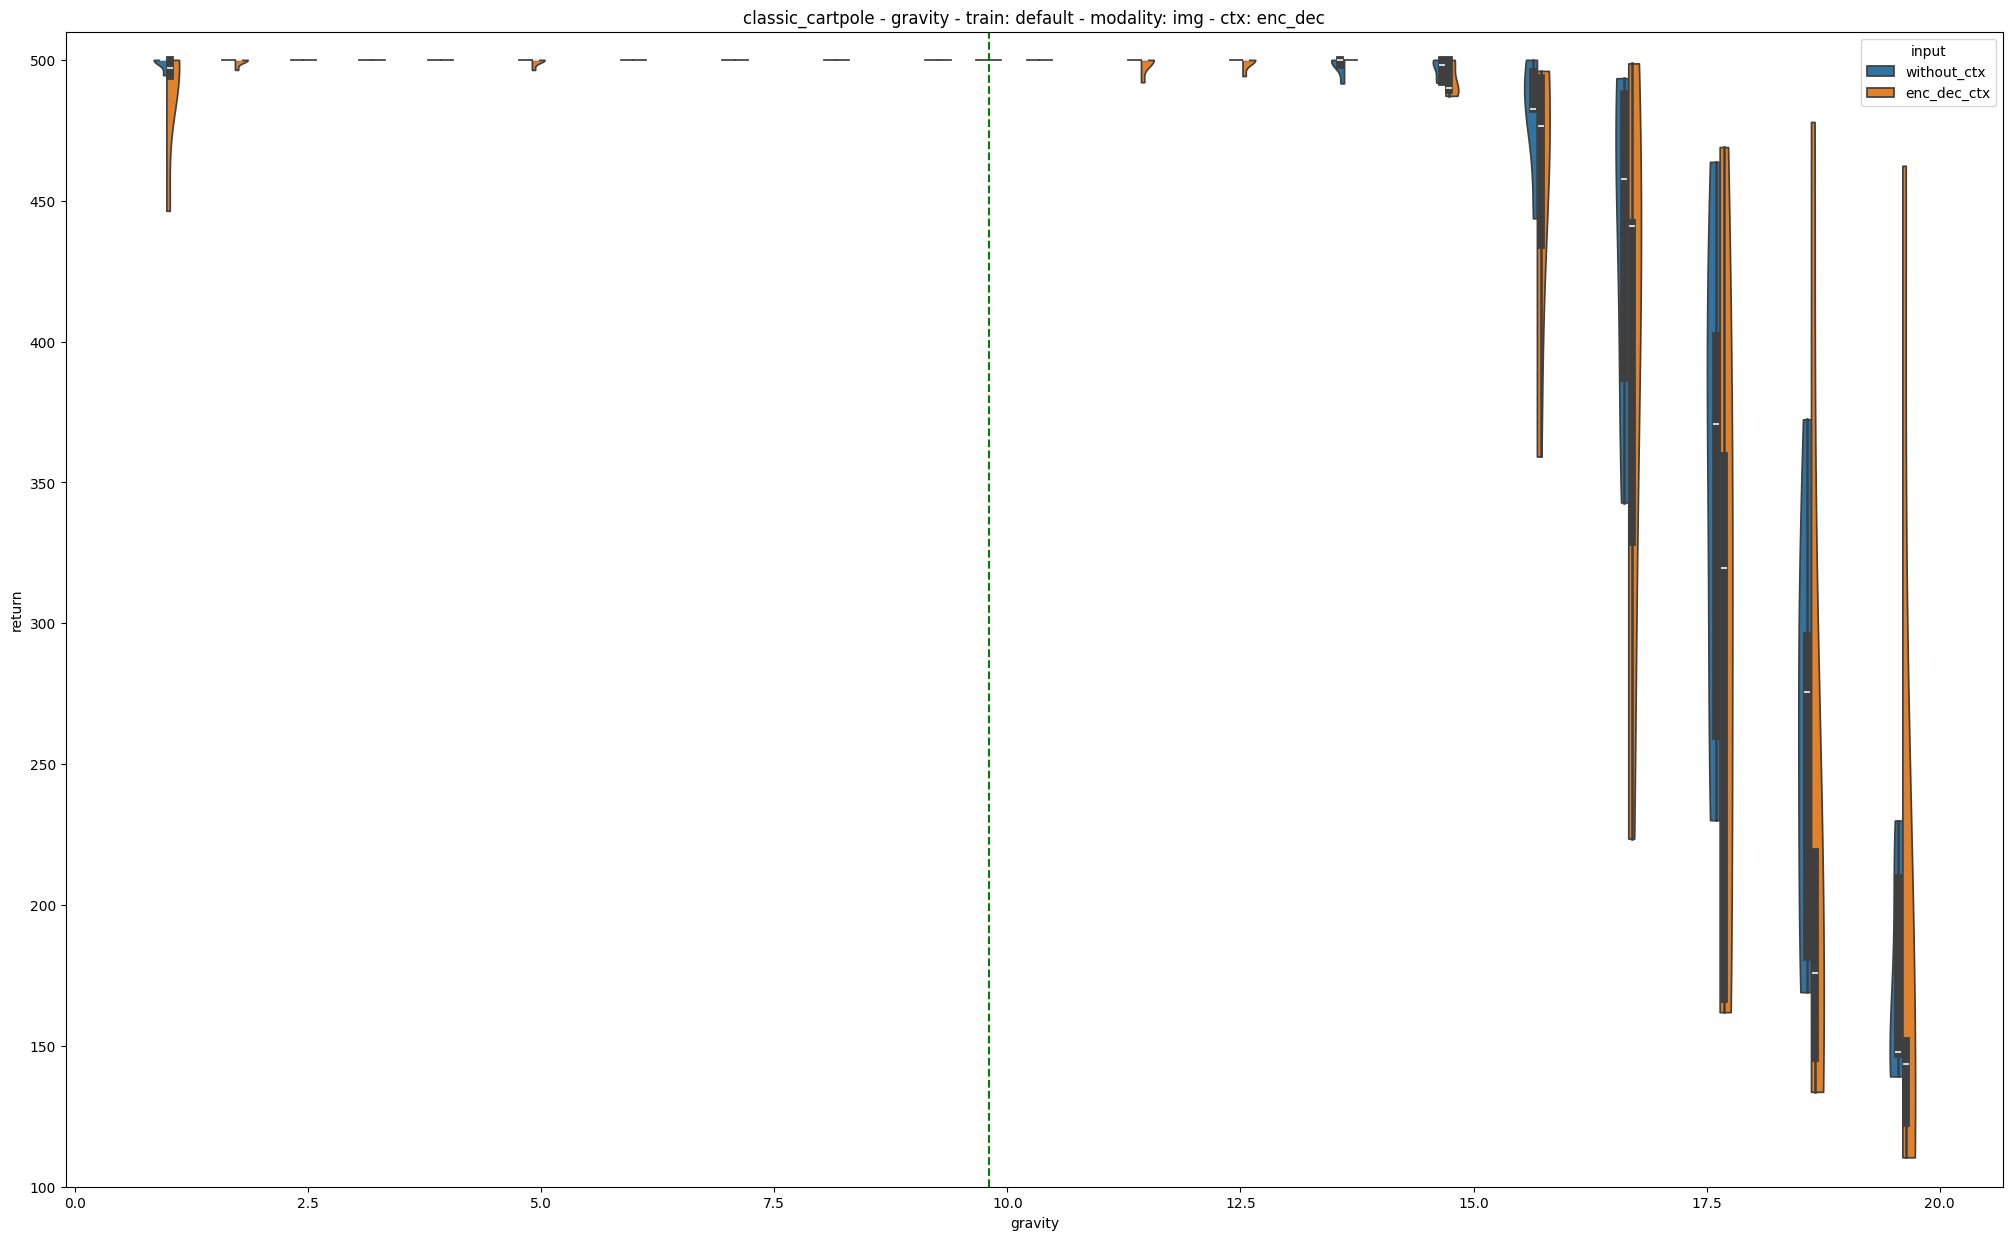

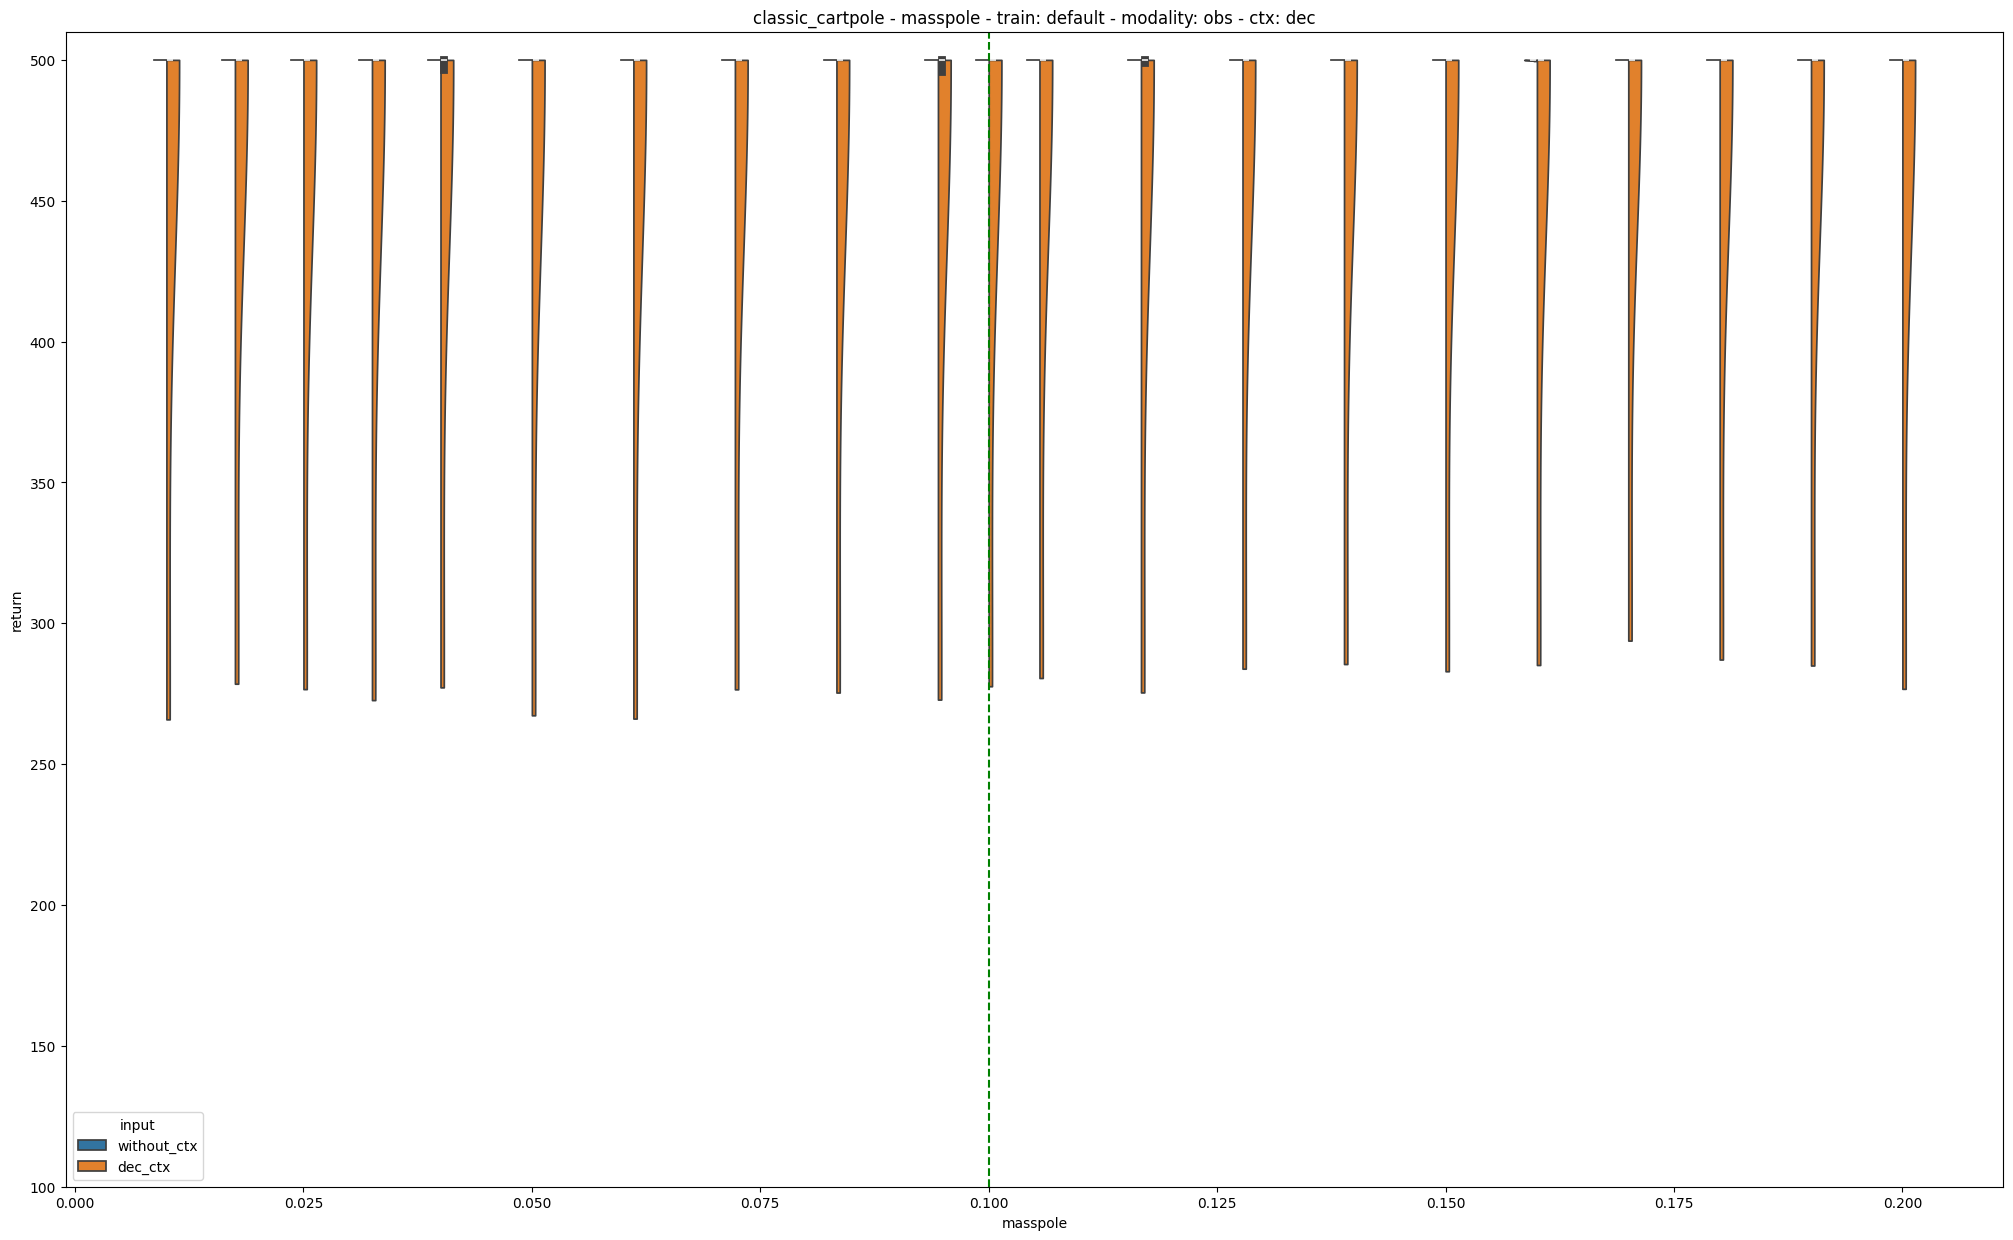

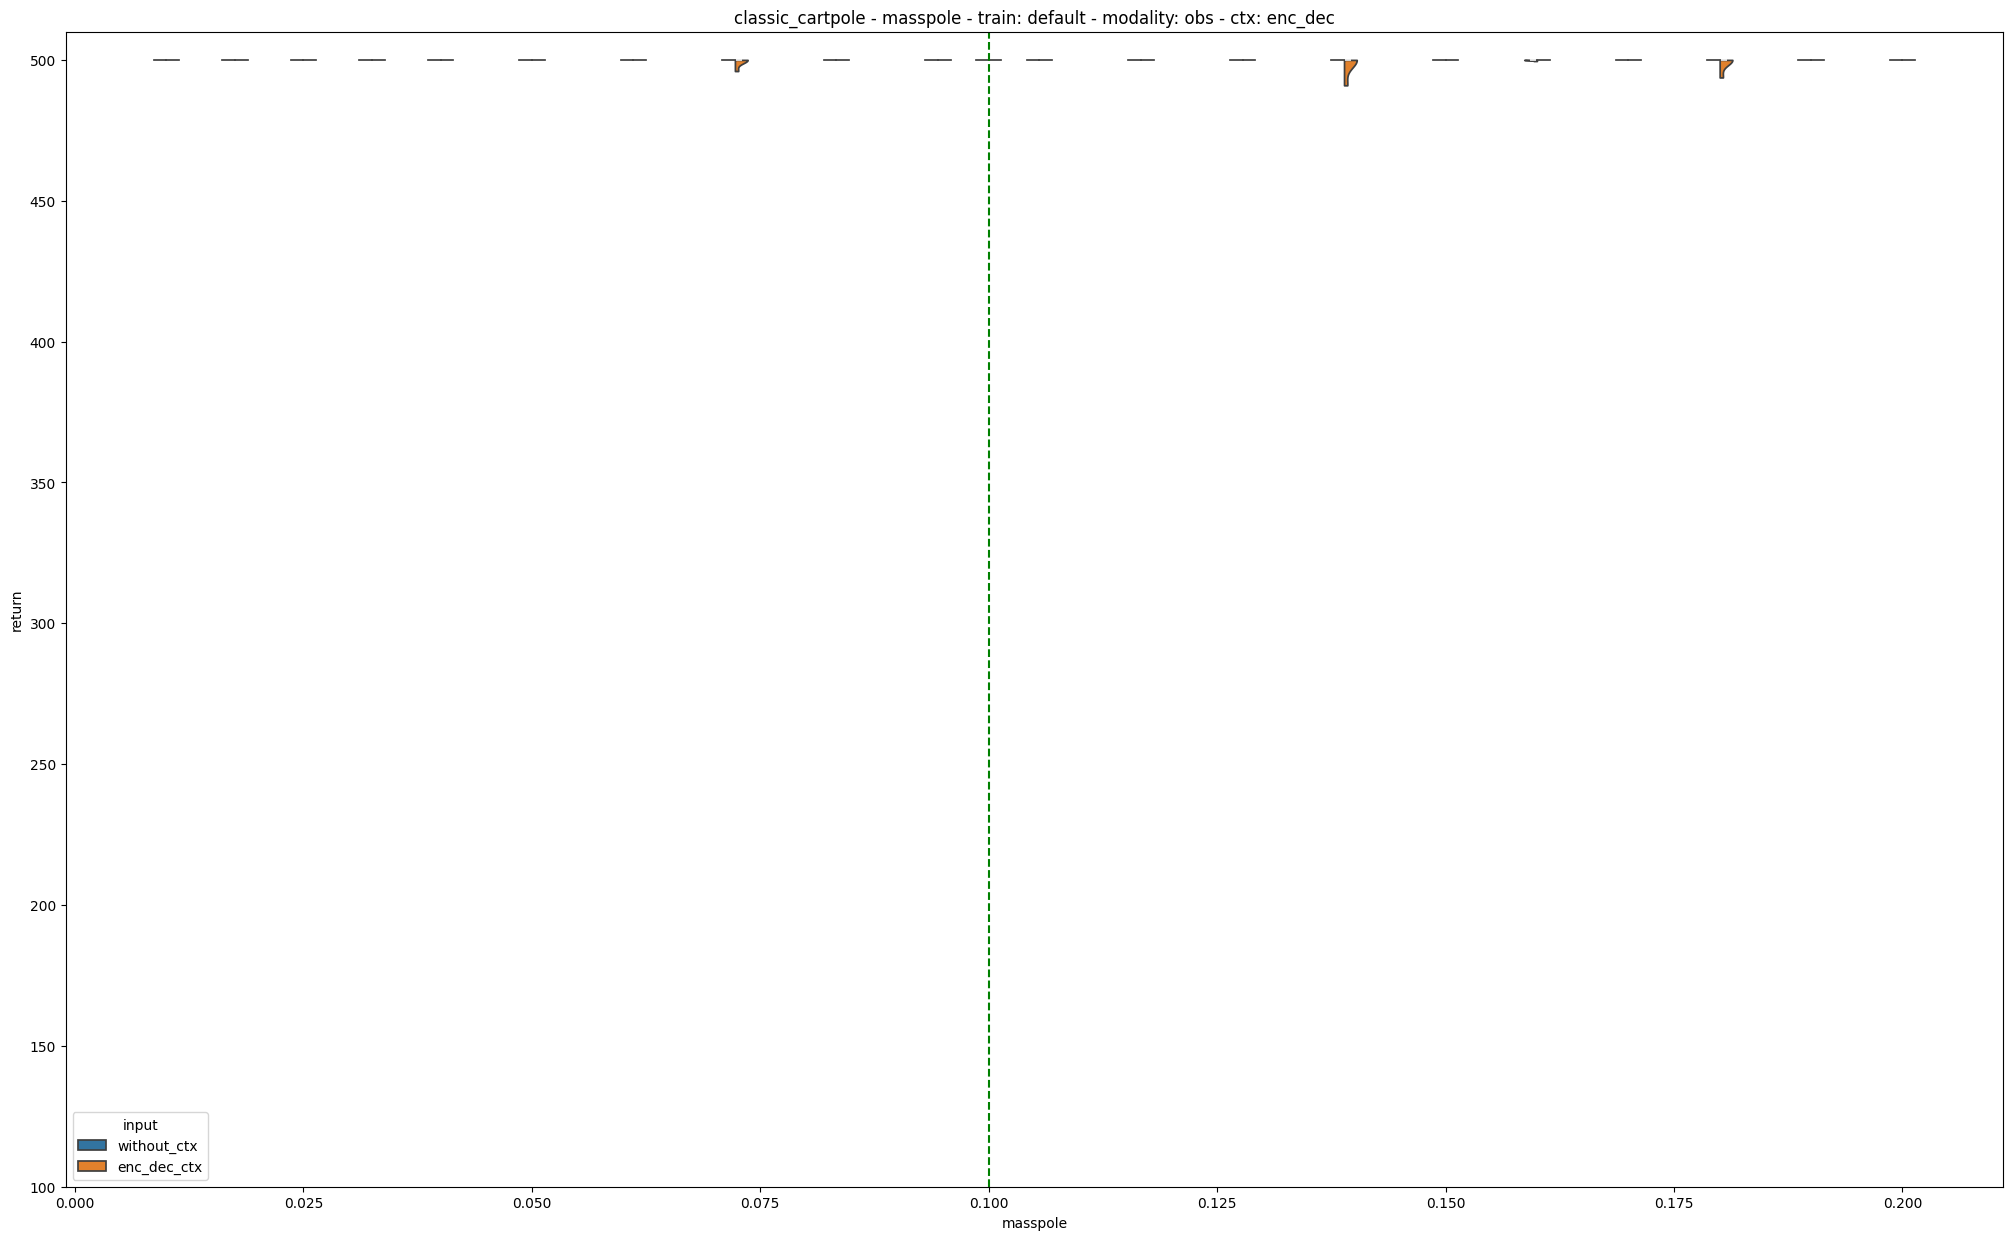

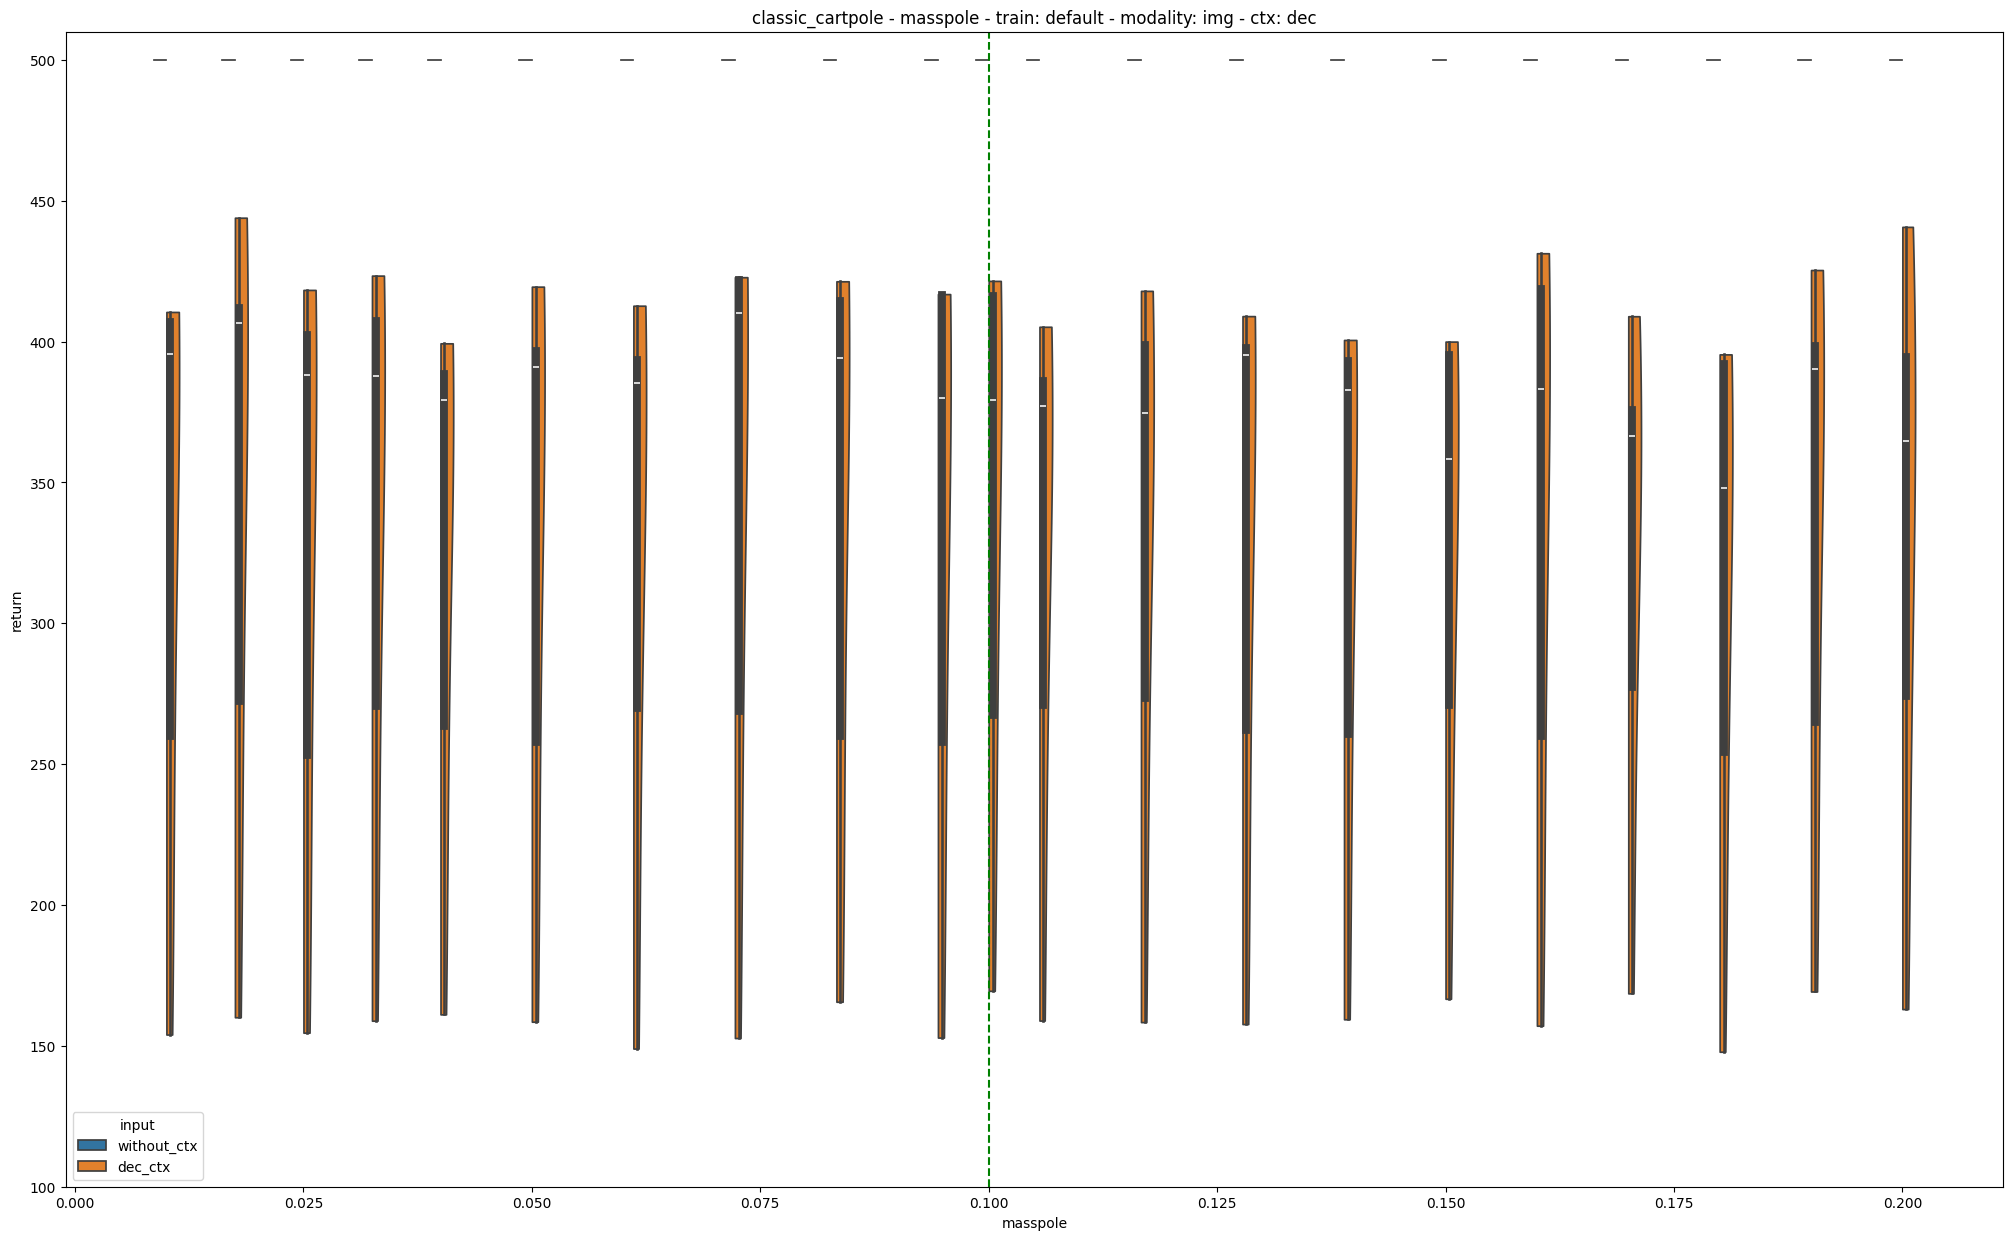

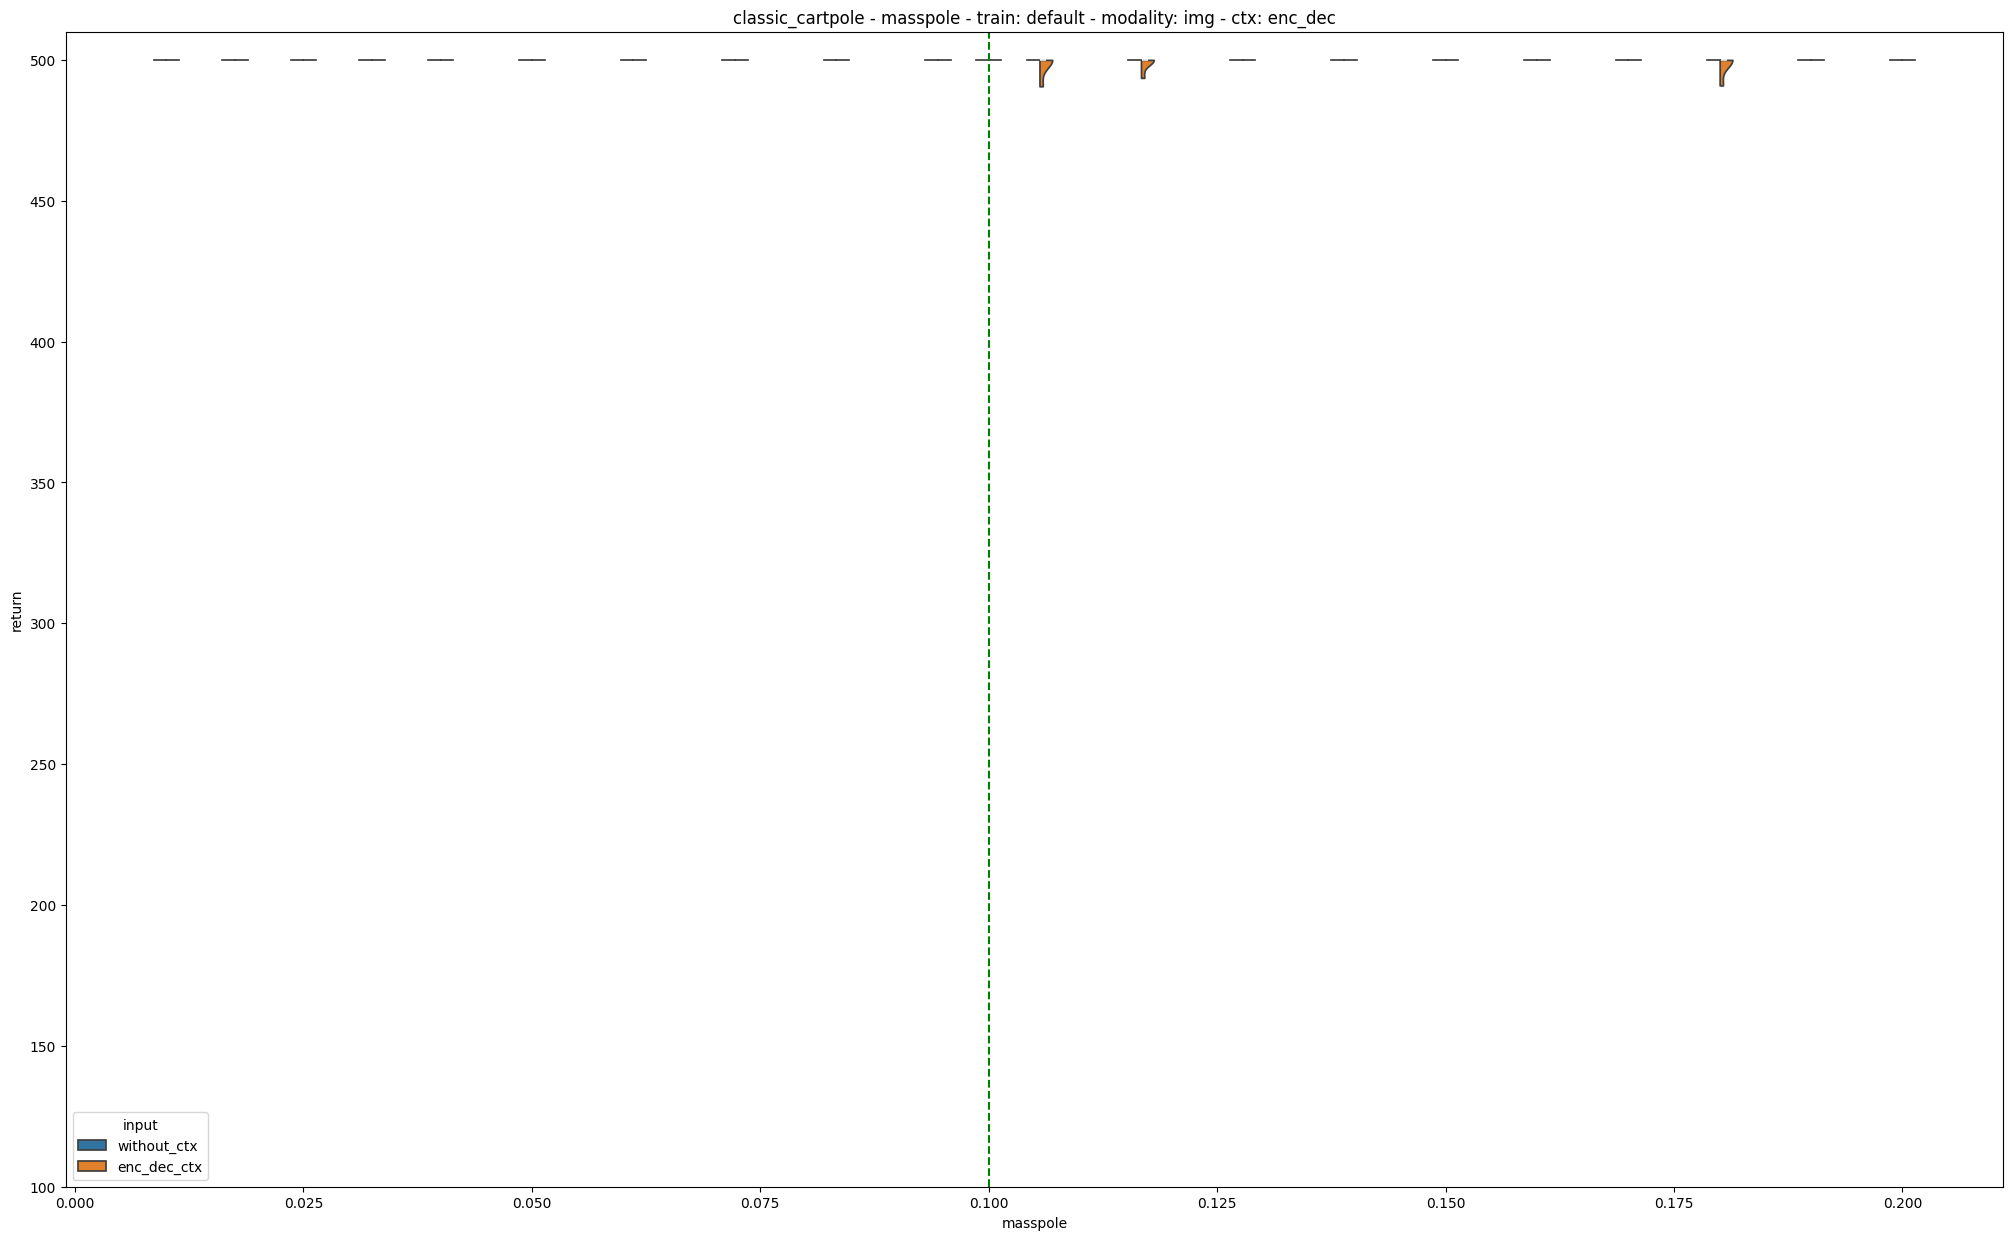

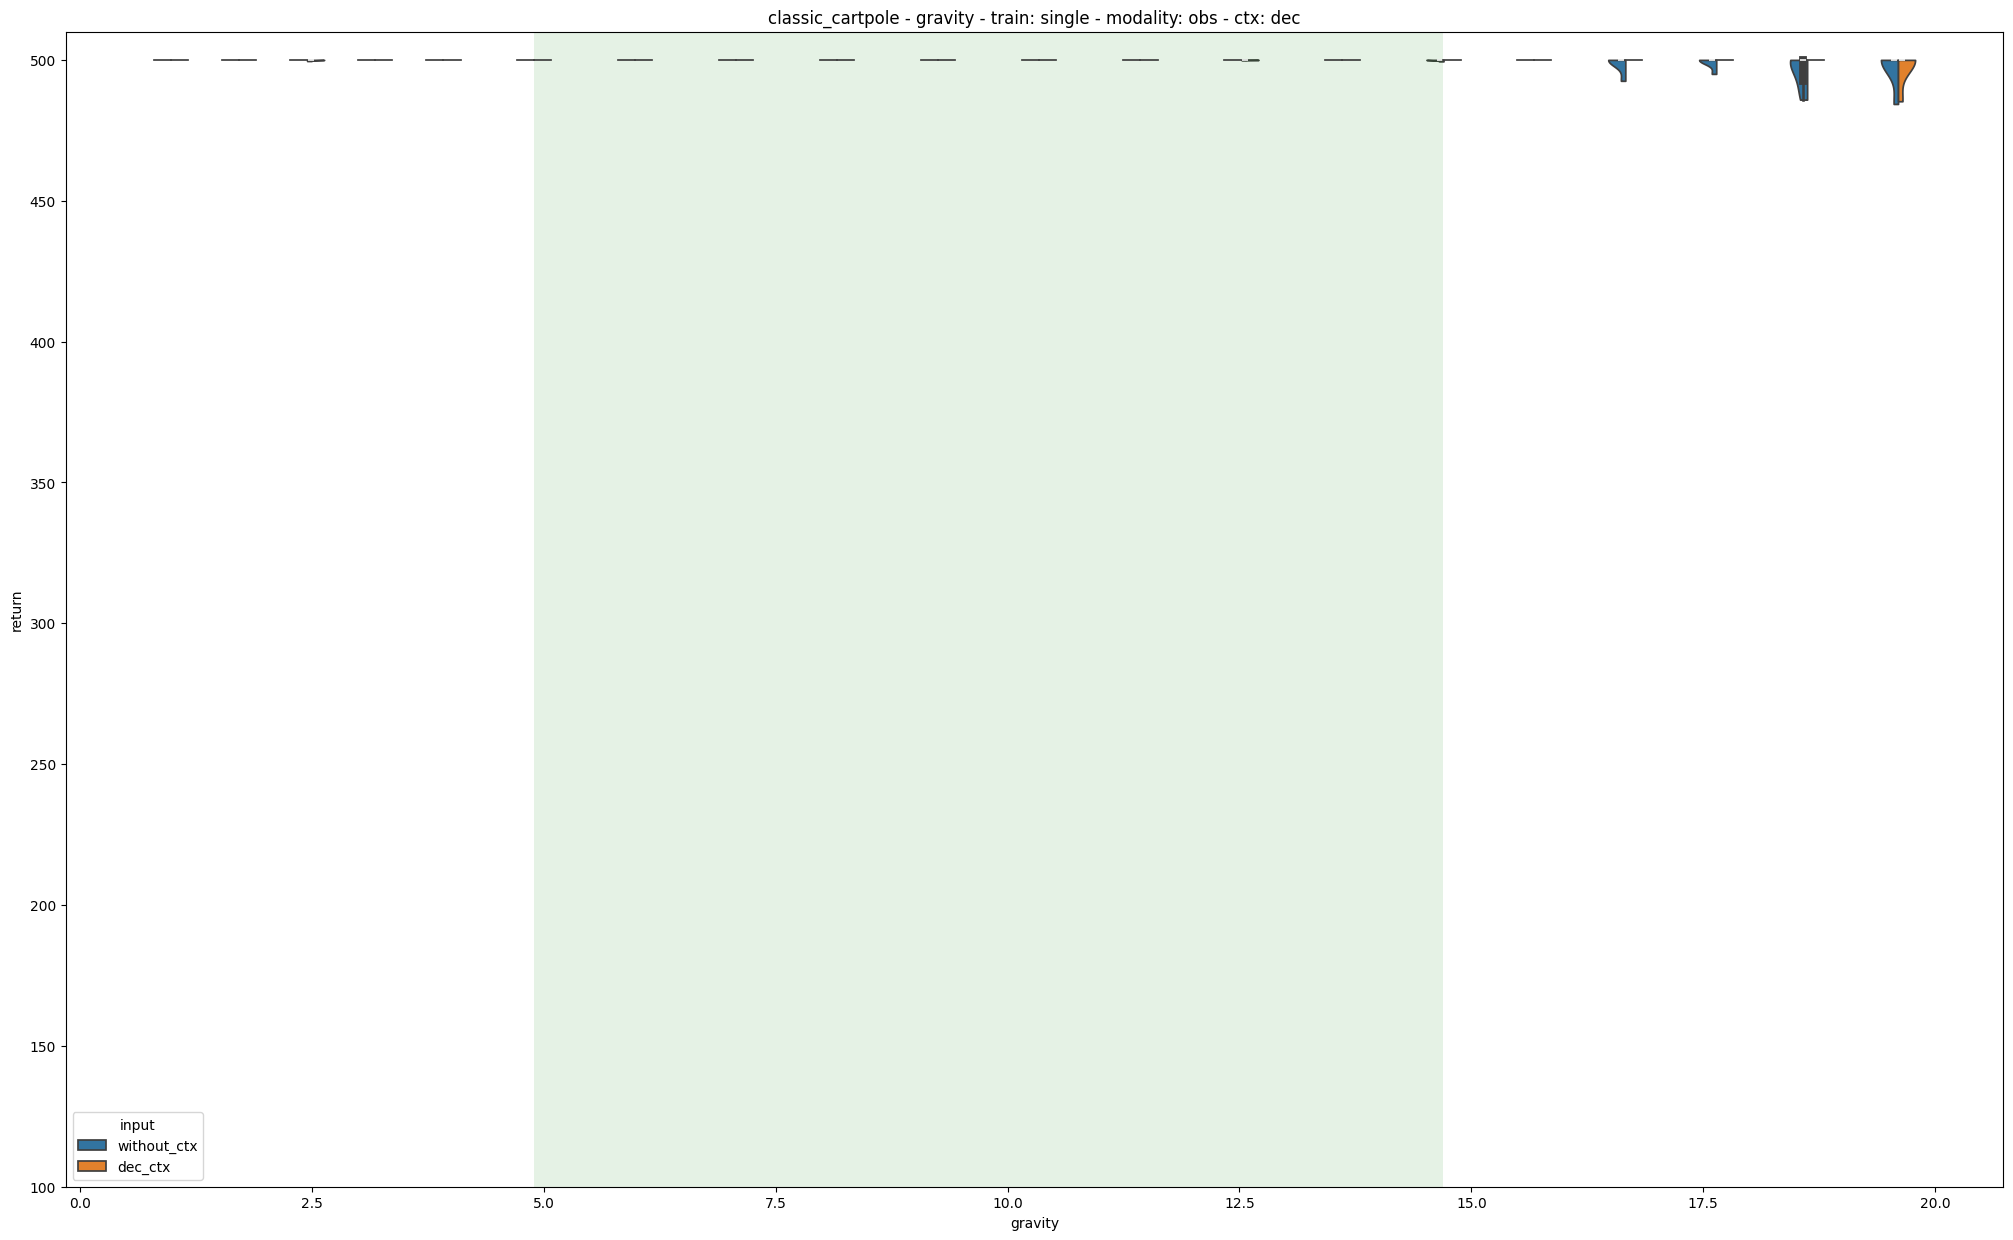

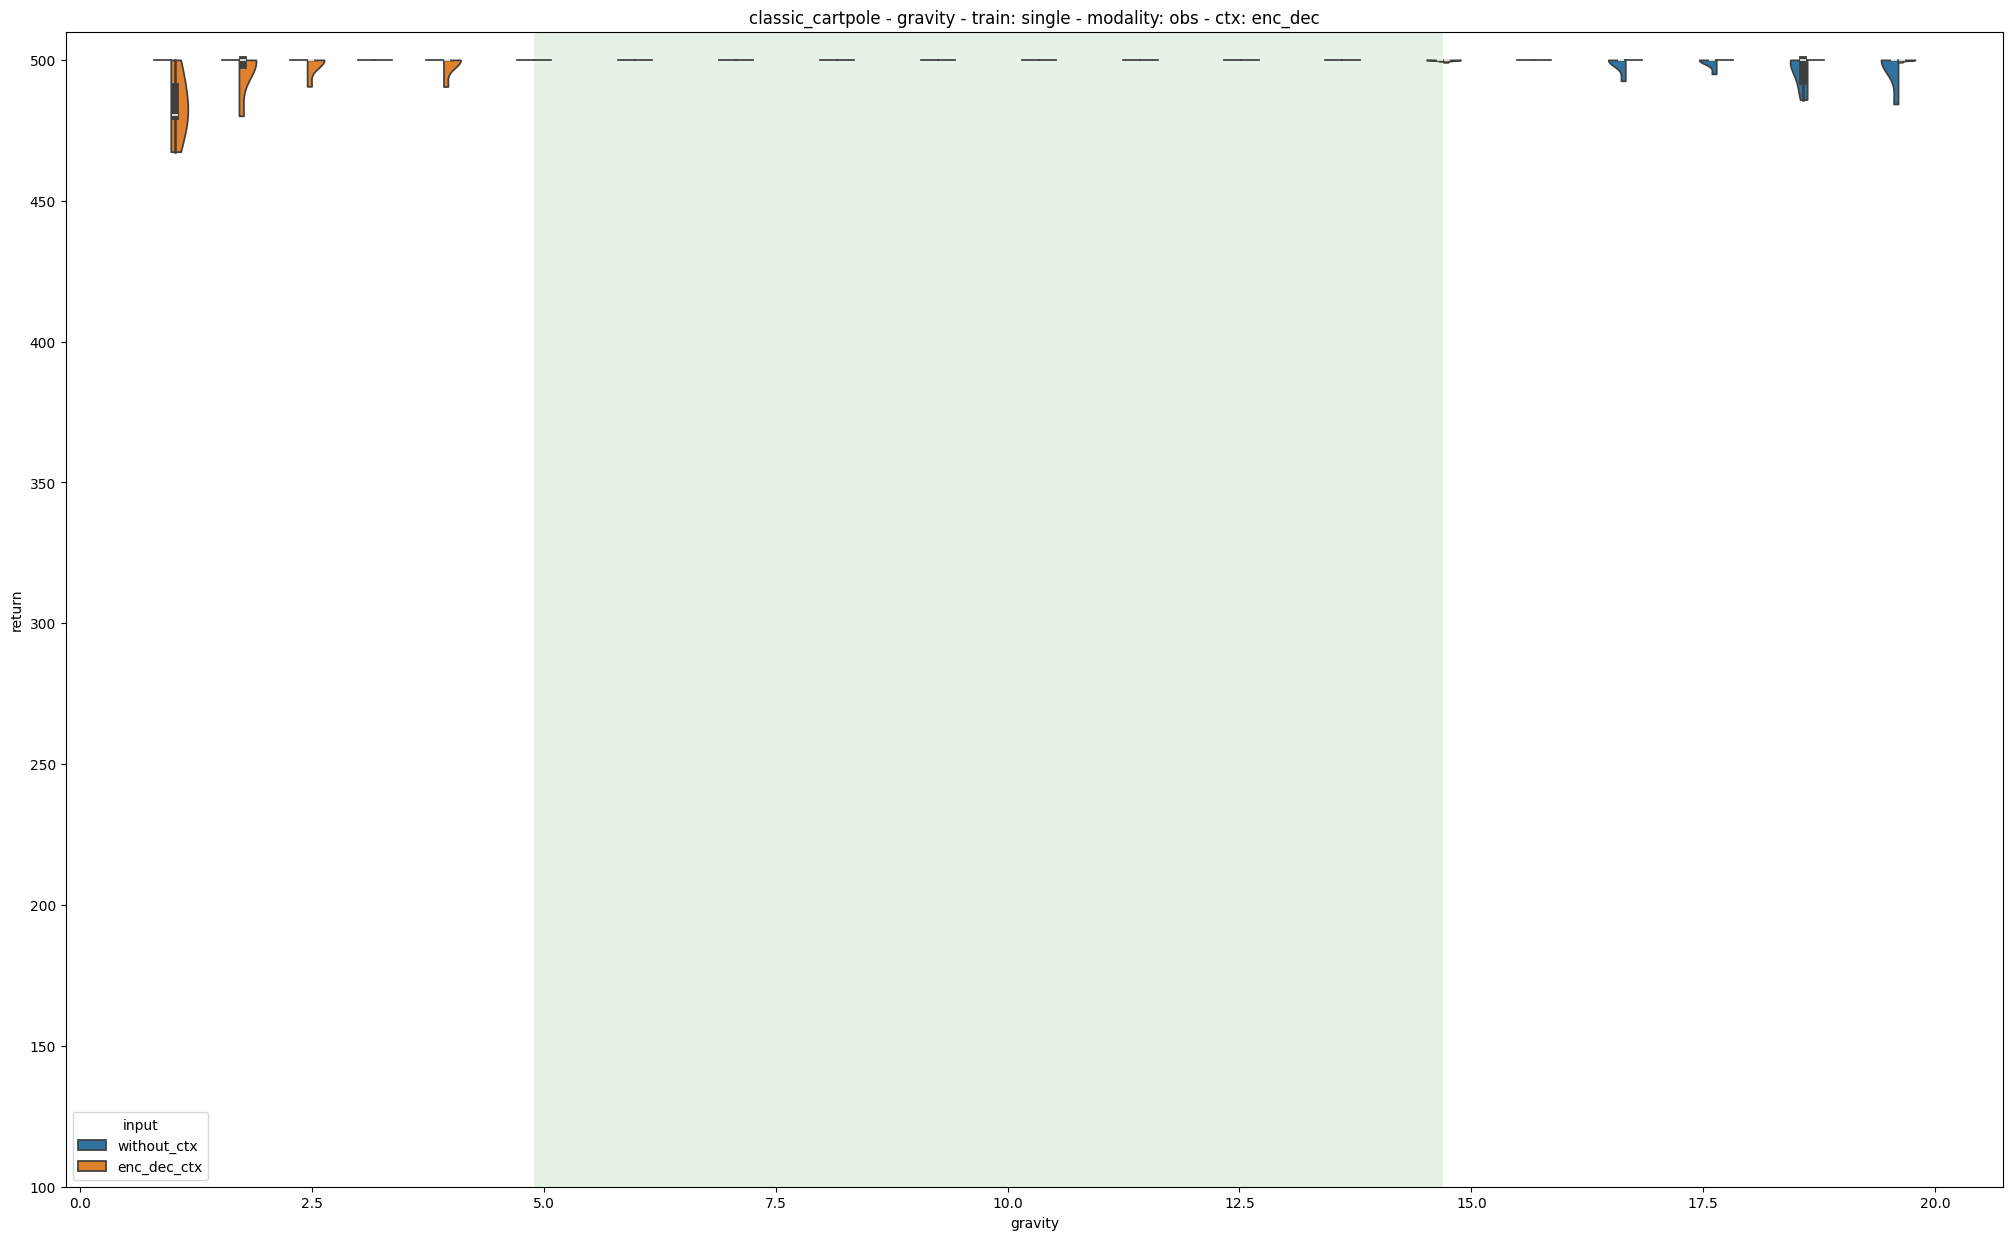

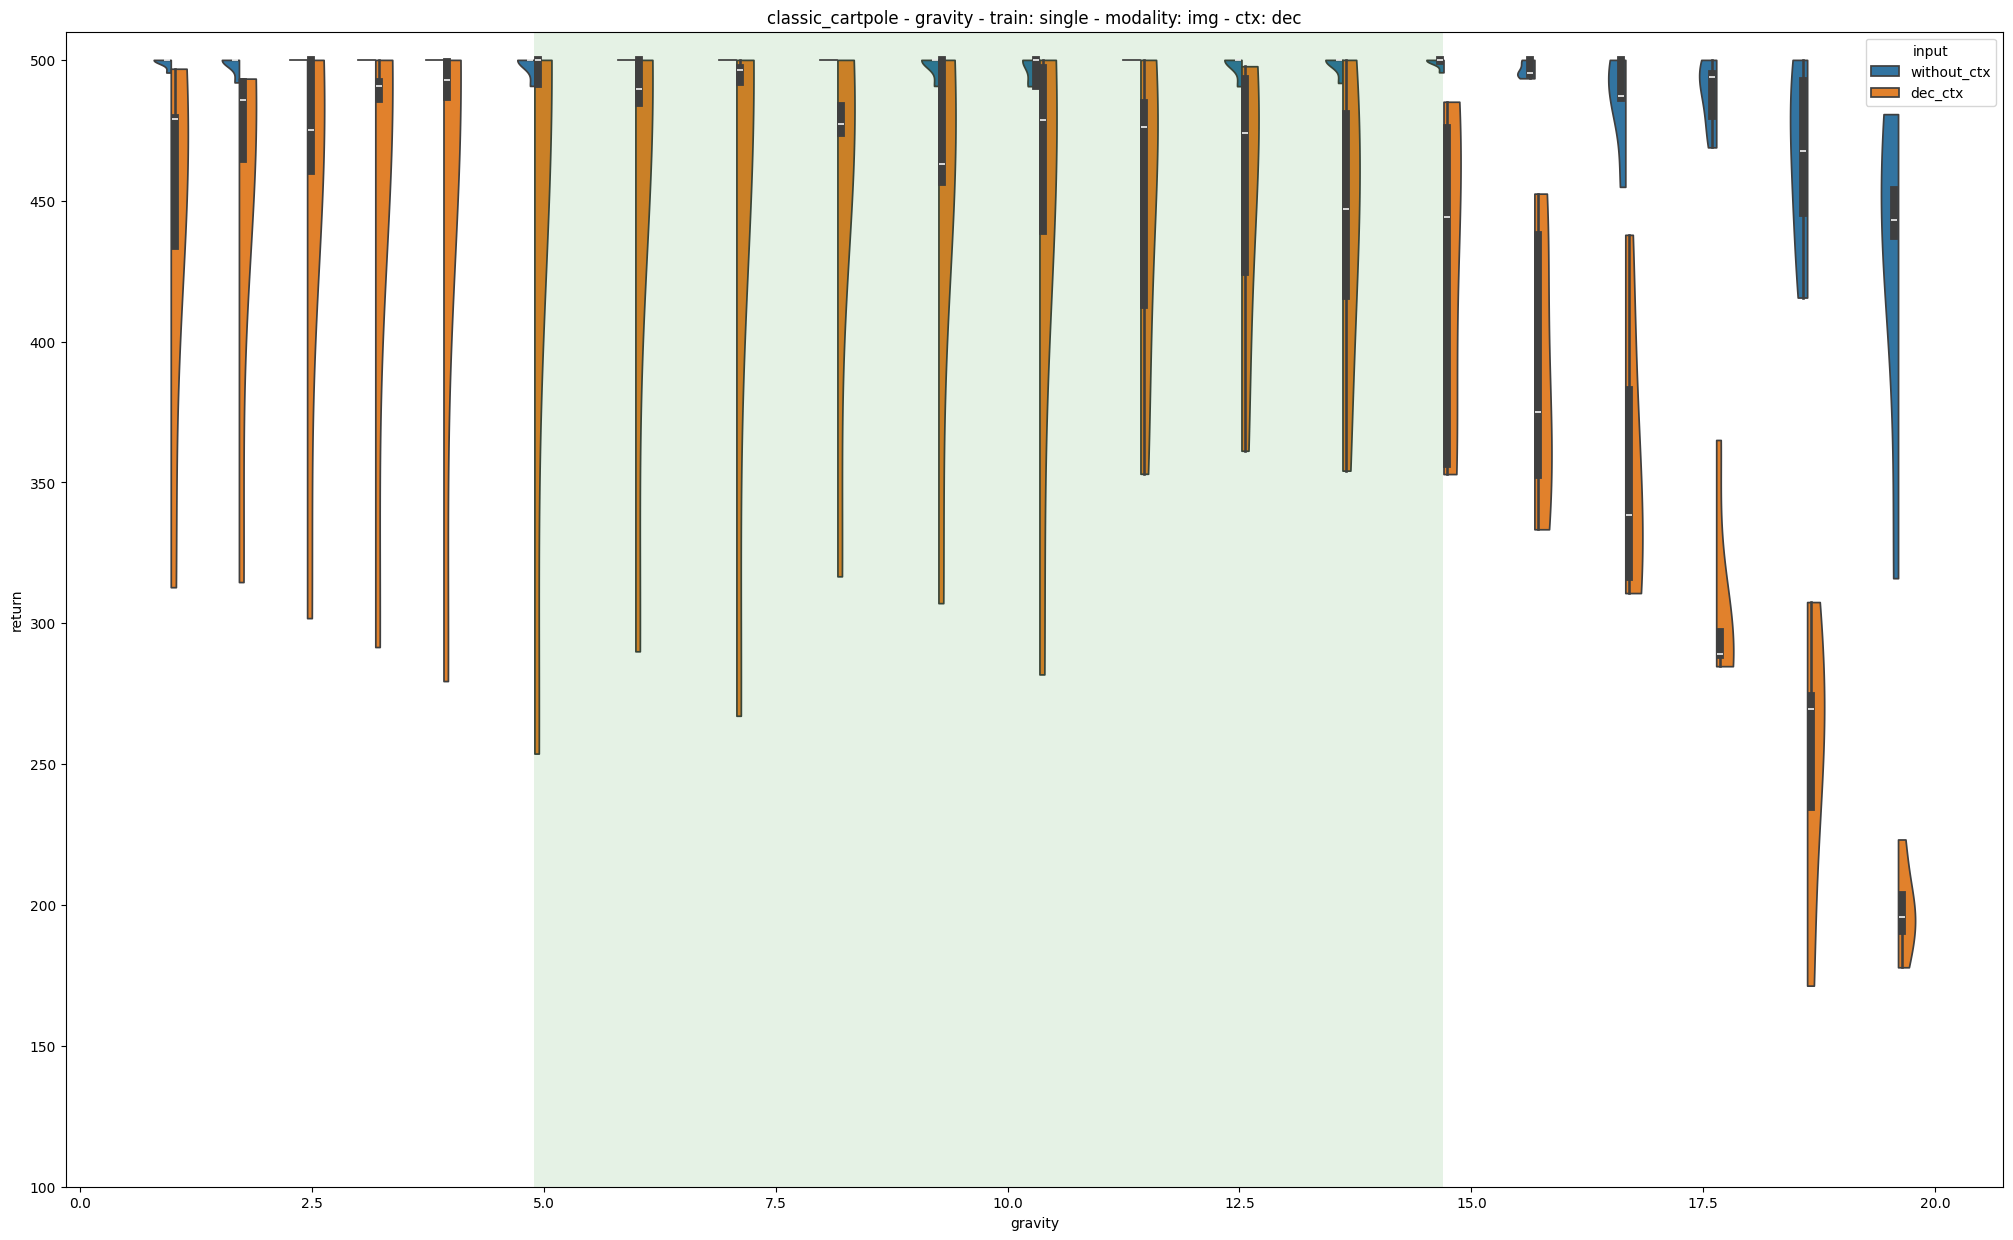

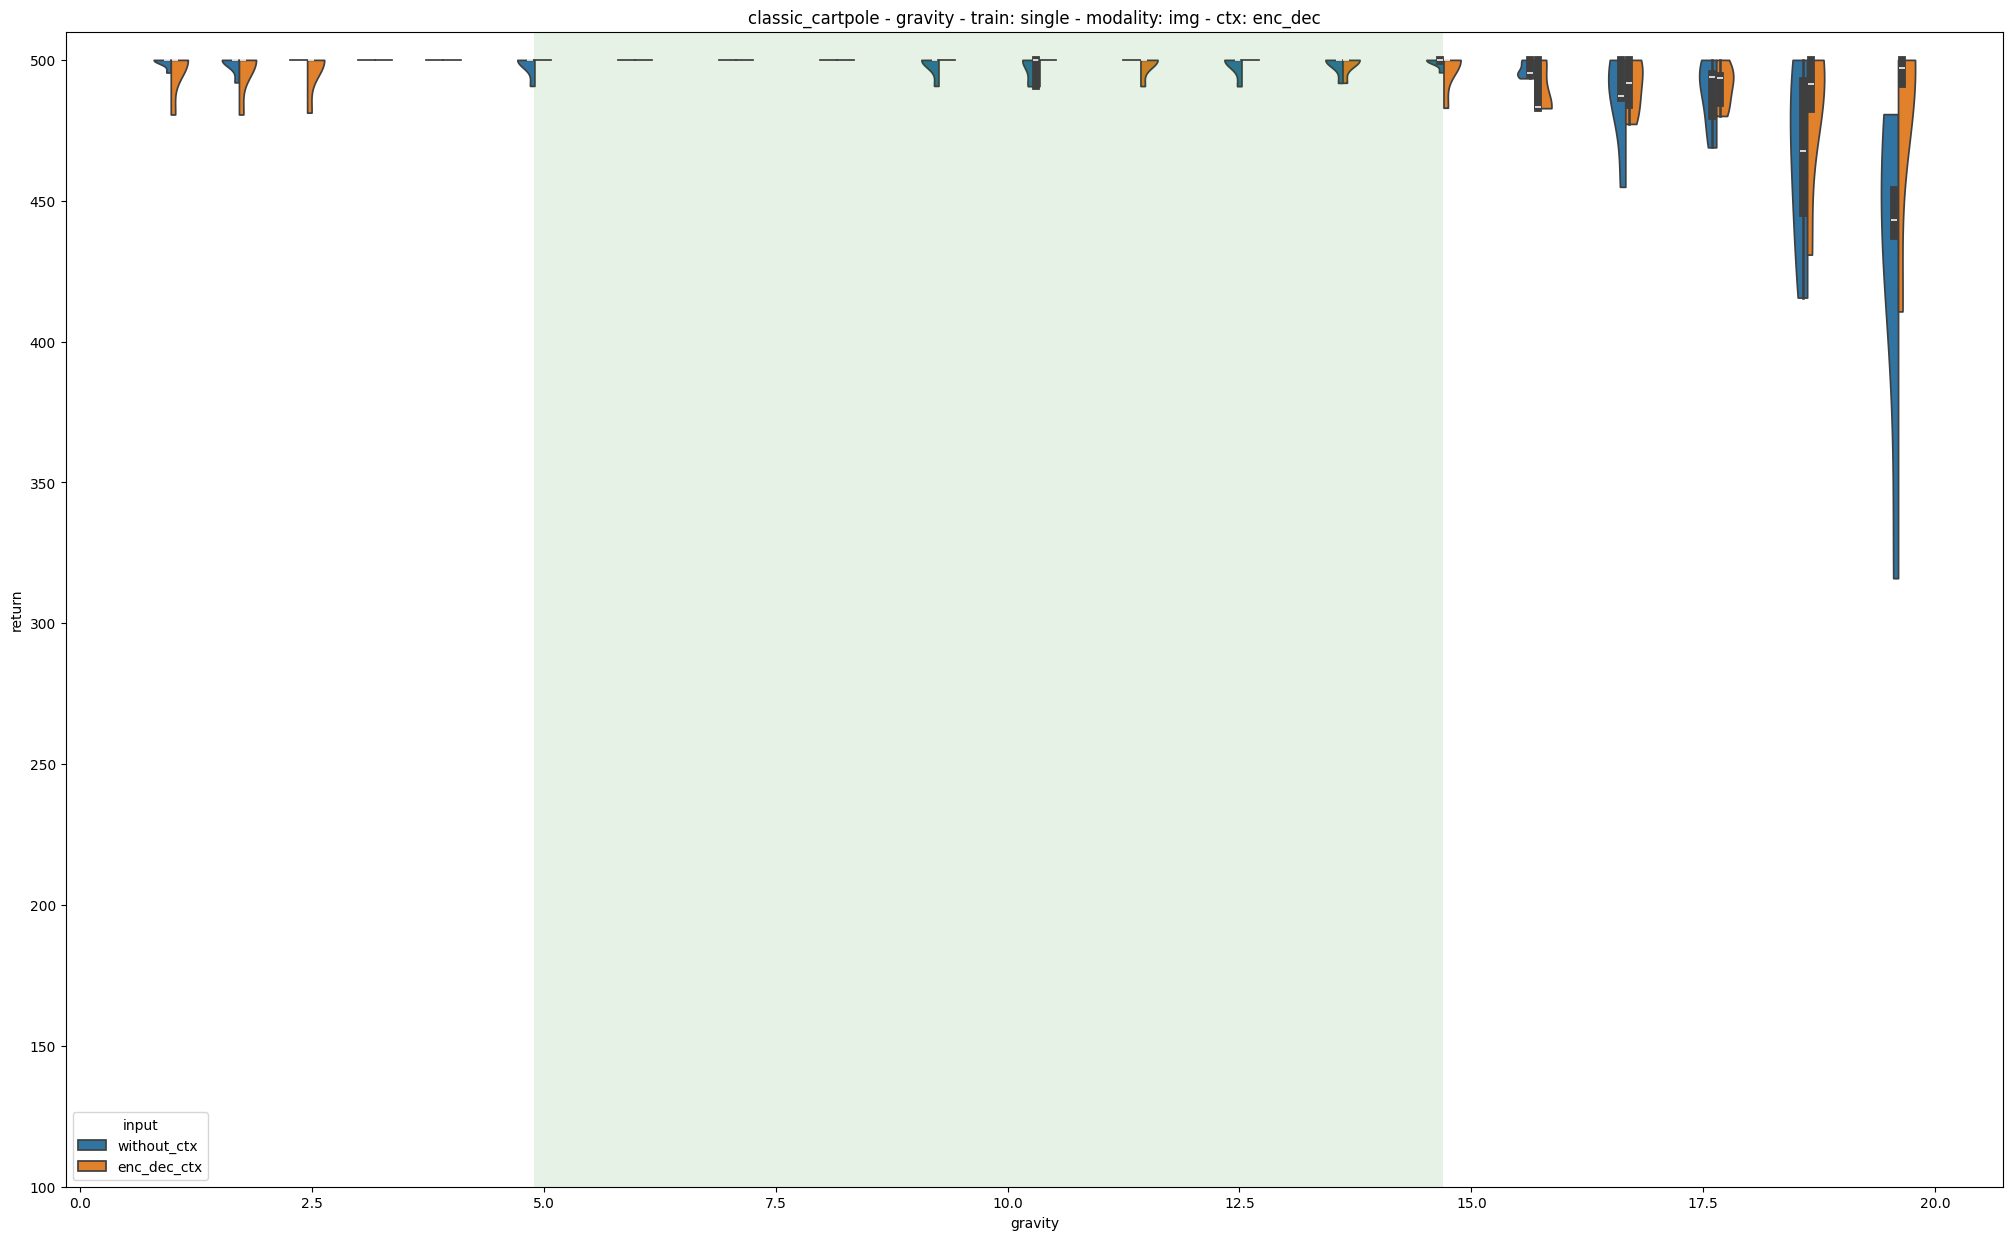

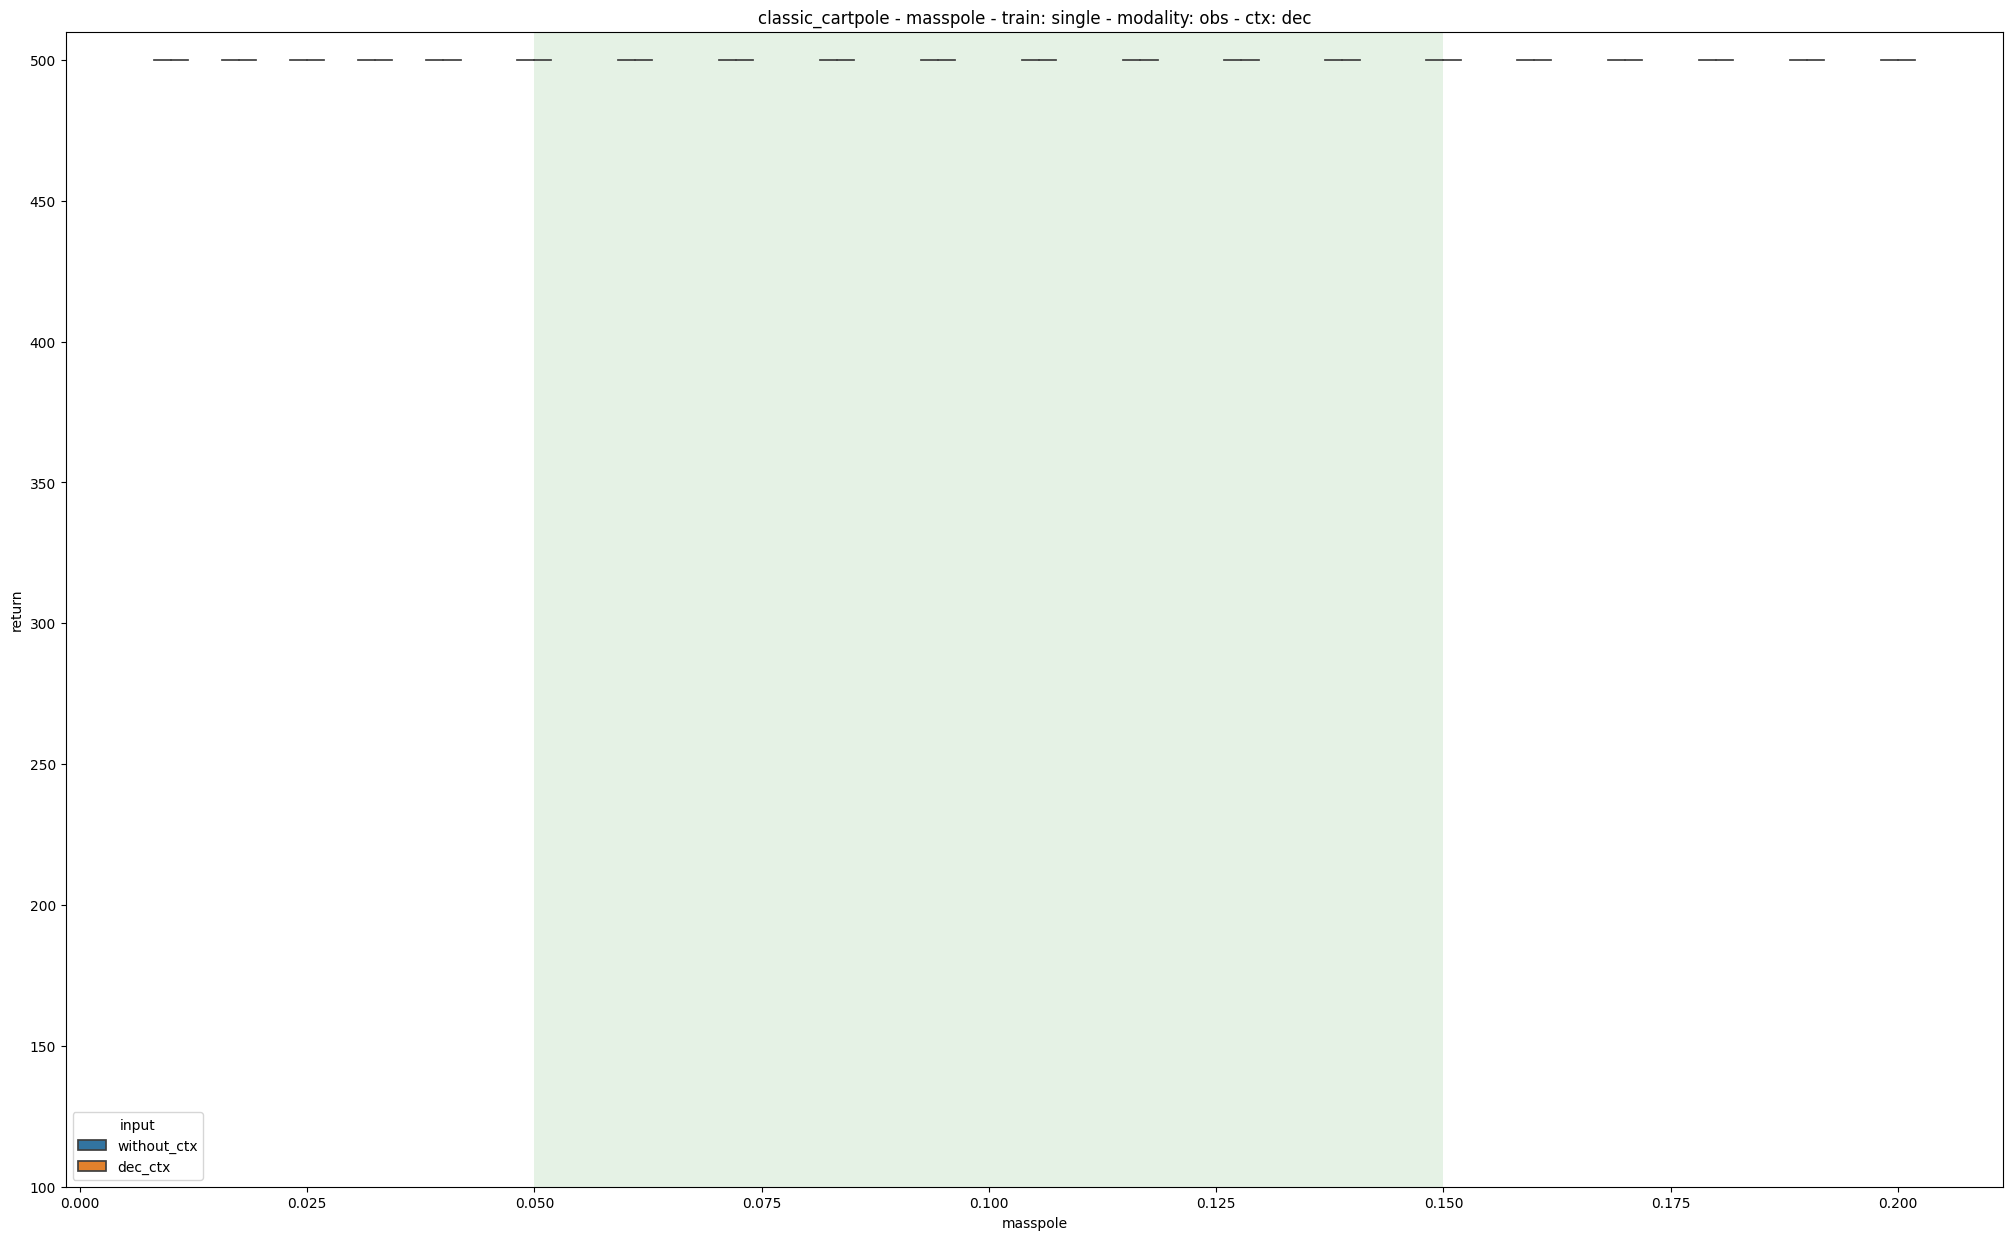

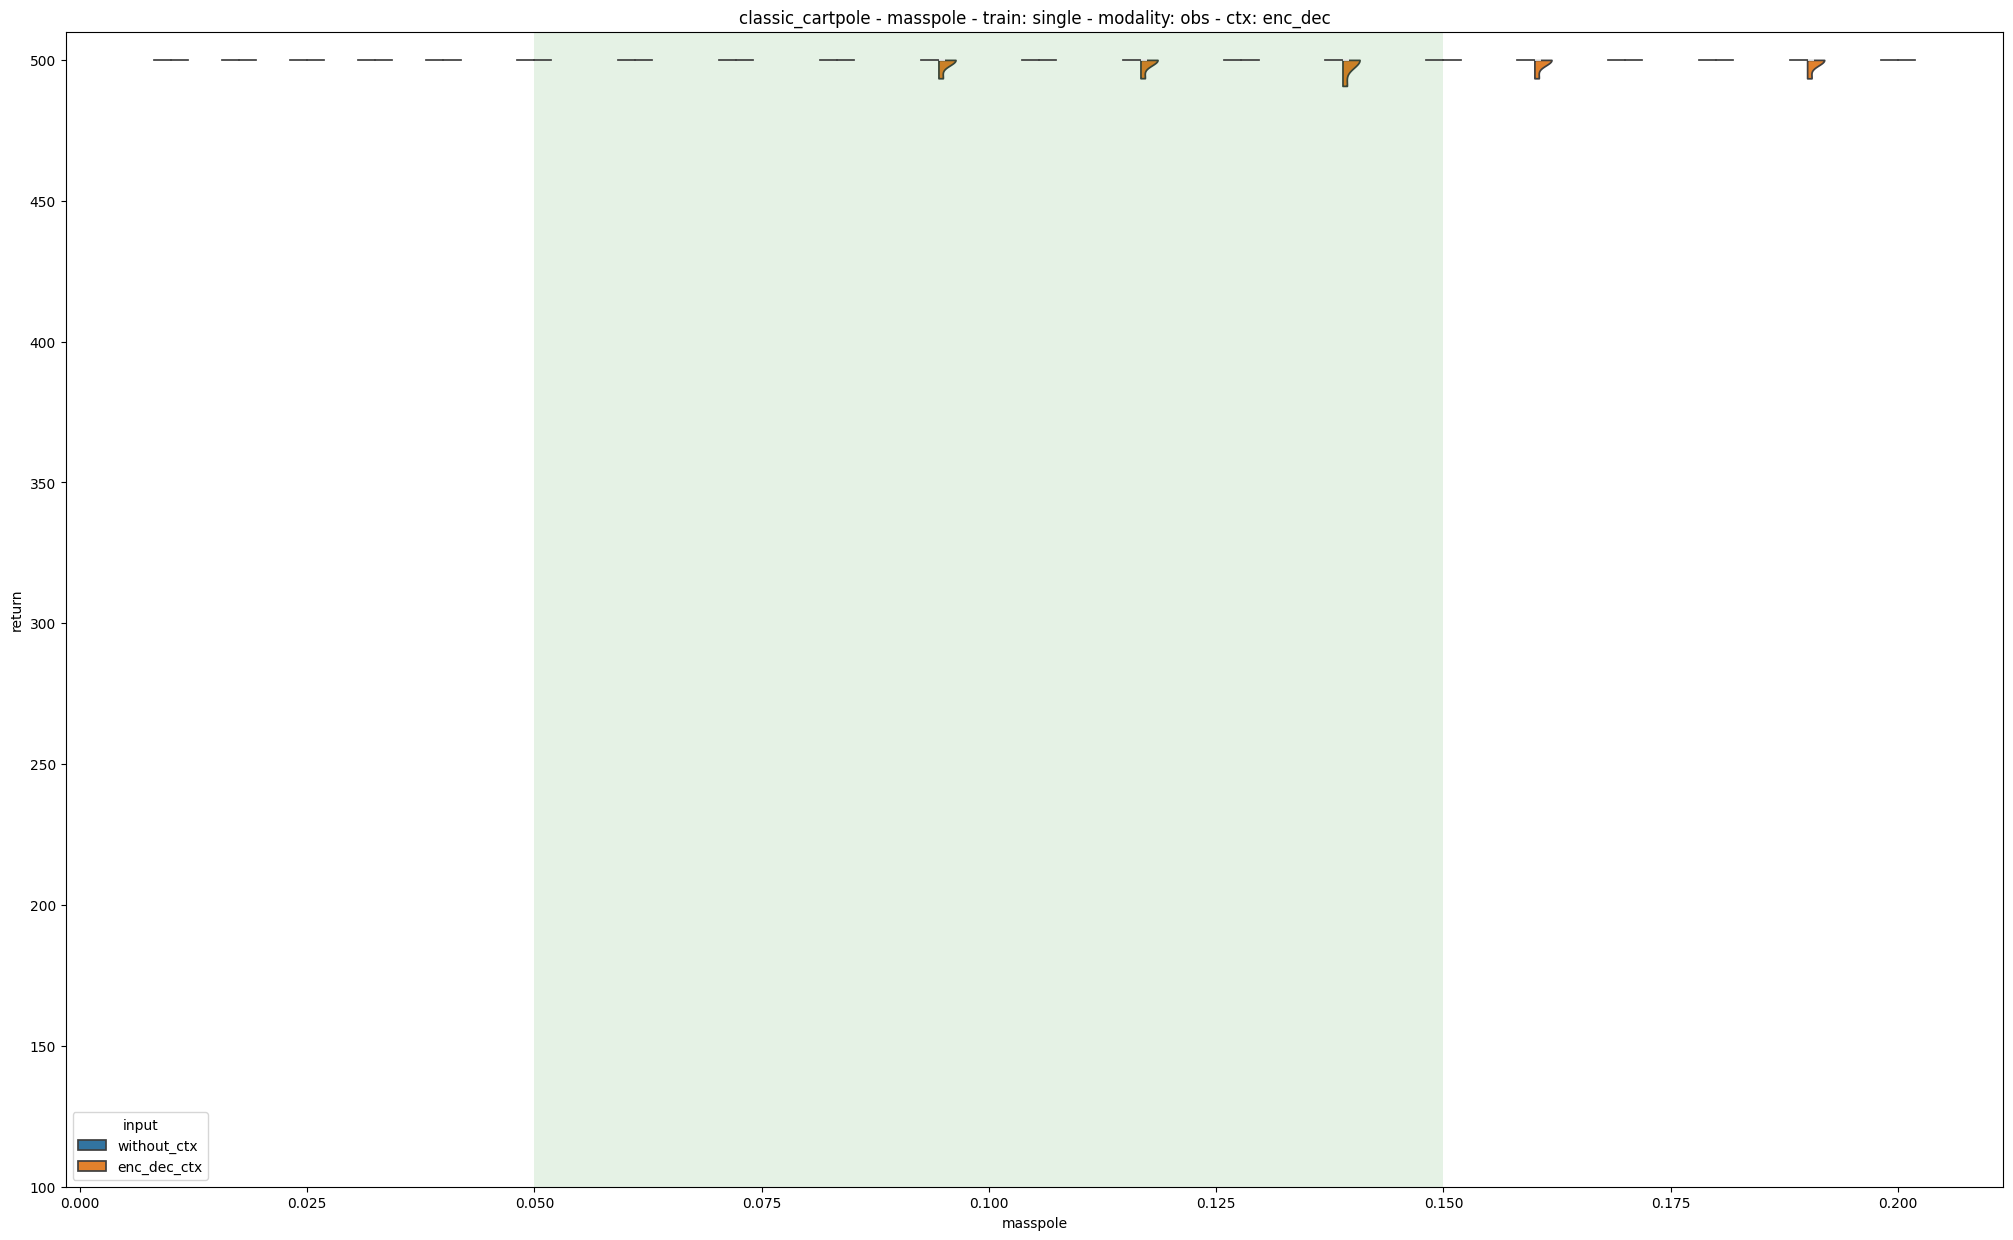

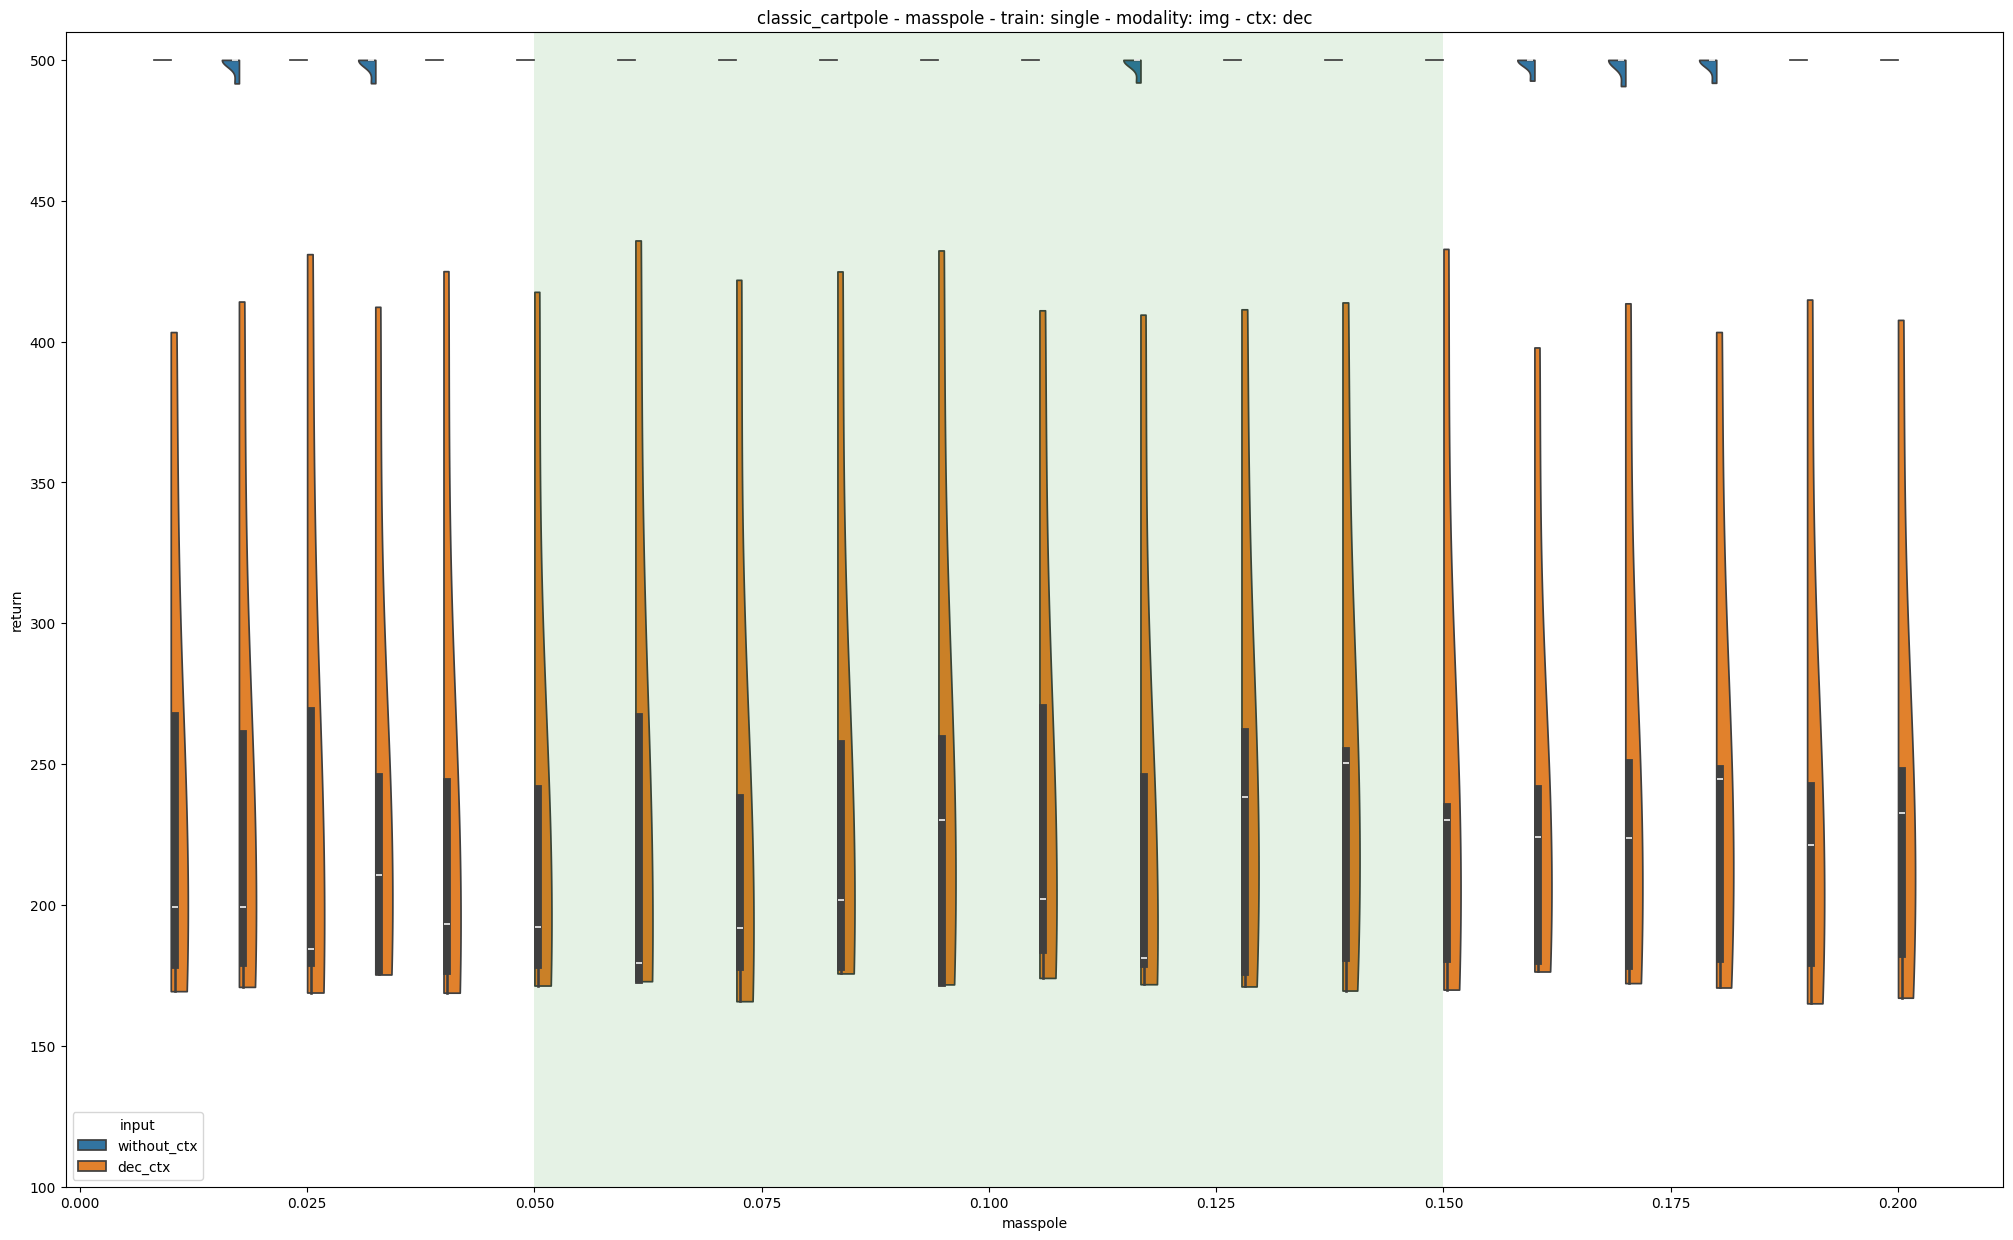

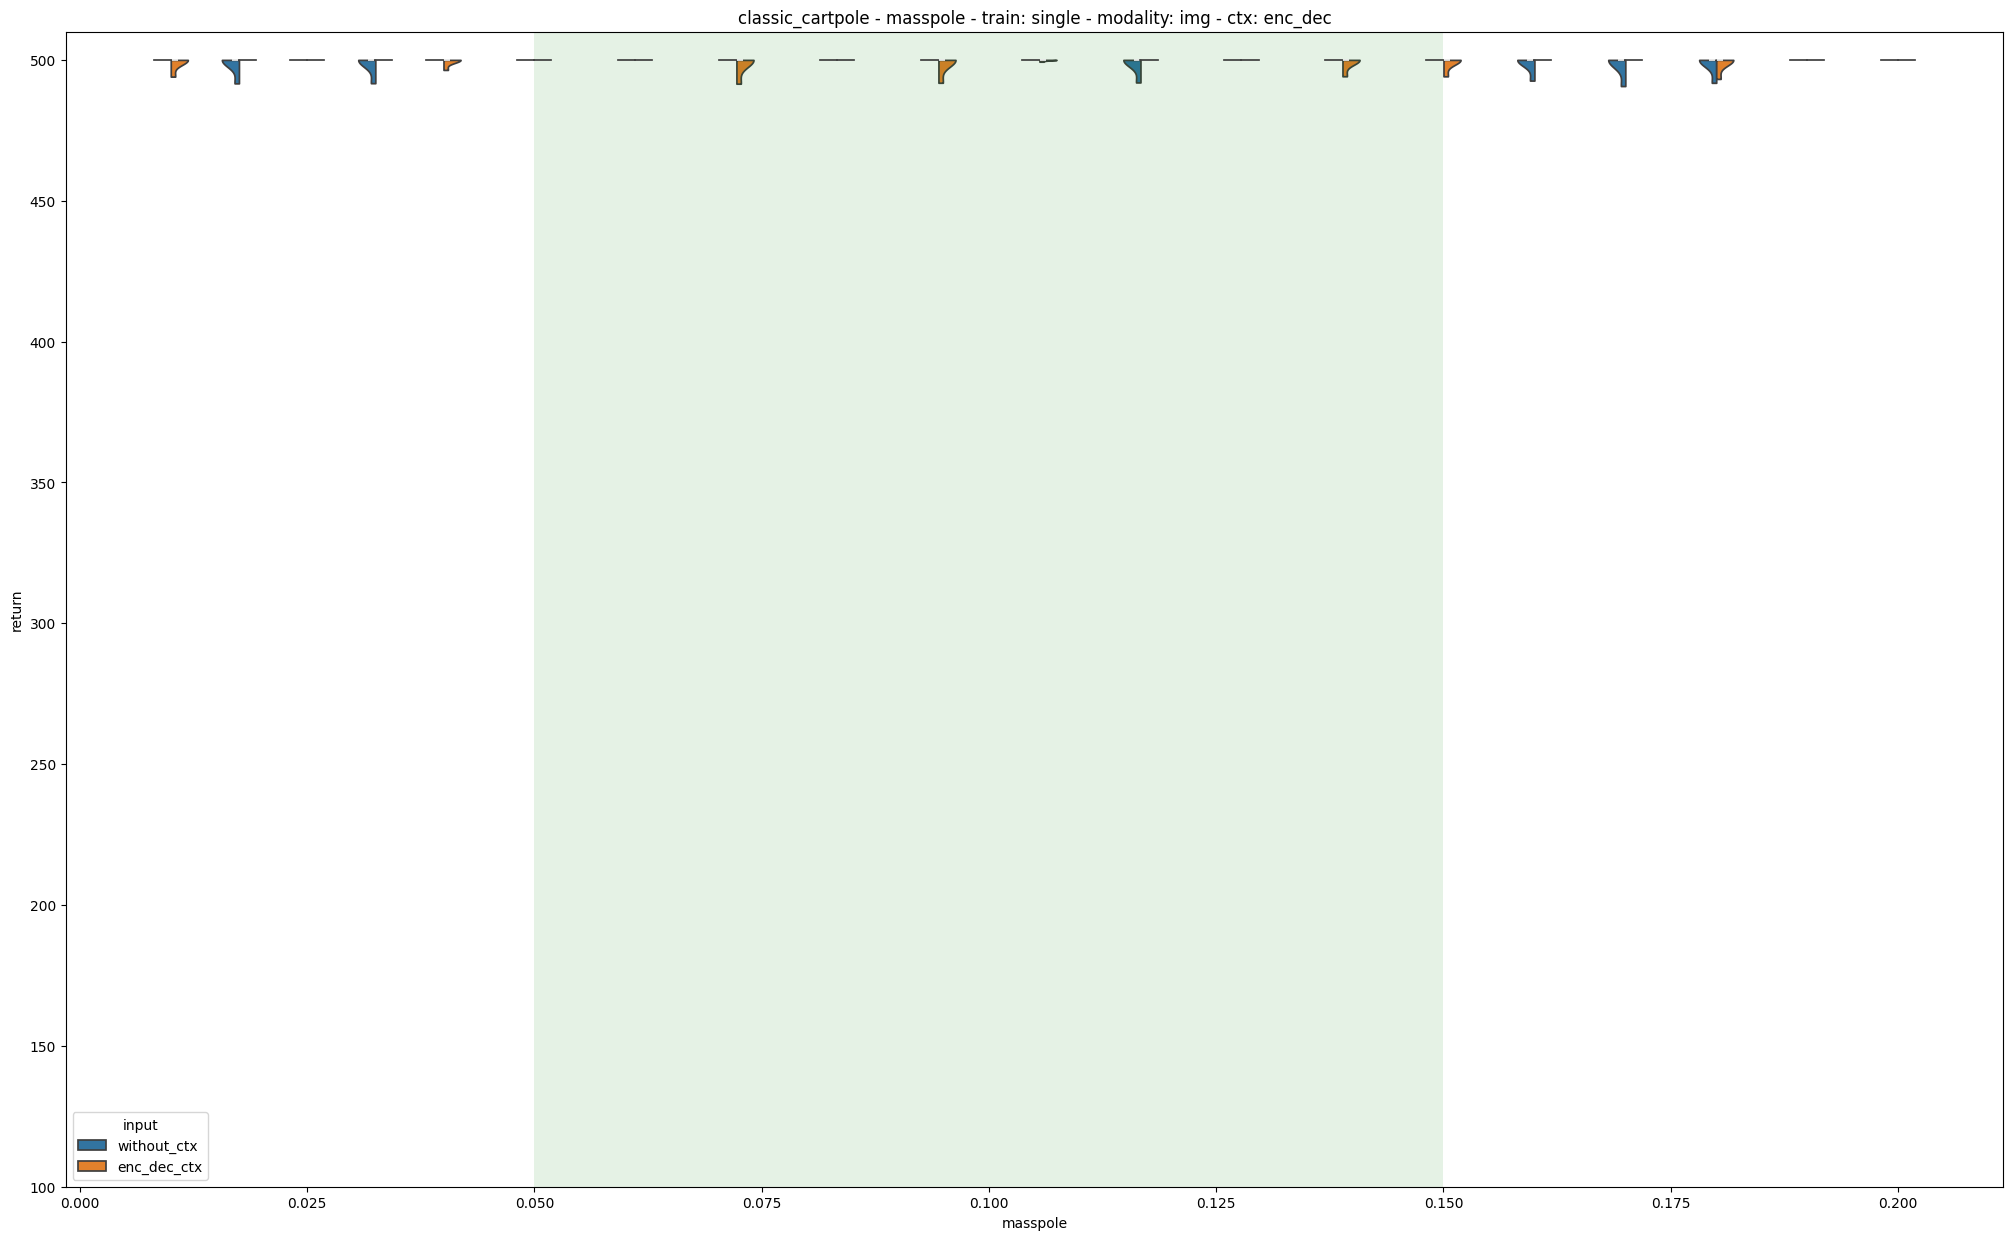

In [1]:
import json
from pathlib import Path

from matplotlib import pyplot as plt
from contextual_mbrl.dreamer.envs import _TASK2CONTEXTS, _TASK2ENV
import pandas as pd
import seaborn as sns

TASK2MaxReturn = {
    "classic_cartpole": 500,
}

def plot_violin_plots(task, train_setting, context_idx, modality, save_dir, log_dir, only_decode_ctx, t_step="50k"):
    train_setting_full = "default" if train_setting == "default" else f"{train_setting}_{context_idx}"

    experiments = [
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}_dec_{modality}_{t_step}", 
        log_dir / f"carl_{task}_{train_setting_full}_enc_{modality}{'_ctx' if not only_decode_ctx else ''}_dec_{modality}_ctx_{t_step}" 
    ] 


    context_name = _TASK2CONTEXTS[task][context_idx]["context"]
    data = {
        "context_val": [],
        "input": [],
        "return": [],
        "dist": []
    }
    ctx_encoding = 'enc_dec' if not only_decode_ctx else 'dec'
    for exp_path in experiments:
        experiment = exp_path.name
        if "ctx" not in experiment:
            inp = "without_ctx"
        else:
            inp = f"{ctx_encoding}_ctx"
        for seed_path in exp_path.iterdir():
            eval_file = seed_path / "eval.jsonl"
            if not eval_file.exists():
                continue
            with eval_file.open() as f:
                lines = f.readlines()
            lines = [json.loads(line) for line in lines if not json.loads(line)['aggregated_context_metric']]
            for line in lines:
                if context_name in line["ctx"]["changed"] or len(line["ctx"]["changed"]) == 0:
                    ctx_value = line['ctx']["context"][context_name]
                    ret = float(line['return'])
                    dist = line['ctx']["dist"]
                    data["context_val"].append(ctx_value)
                    data["input"].append(inp)
                    data["return"].append(ret)
                    data["dist"].append(dist)
    df = pd.DataFrame.from_dict(data)
    env = _TASK2ENV[task]
    default_context_val = env.get_default_context()[context_name]
    if train_setting == "default":
        interpolate_range = [default_context_val, default_context_val]
    else:
        interp_range_pct = _TASK2CONTEXTS[task][context_idx]["interpolate"][0]
        interpolate_range = [default_context_val * interp_range_pct[0], default_context_val * interp_range_pct[1]]
    
    plt.figure(figsize=(25,15))
    sns.violinplot(data=df, x="context_val", y="return", hue="input", split=True, cut=0, native_scale=True, density_norm="width", width=0.5)
    plt.xlabel(context_name)
    if interpolate_range[0] == interpolate_range[1]:
        # draw a vertical line at the context value
        plt.axvline(interpolate_range[0], color='g', linestyle='--')
    else:
        # in the interpolate range, set the background color to green
        plt.axvspan(interpolate_range[0], interpolate_range[1], facecolor='g', alpha=0.1)
    # set the y axis to go from 0 to max return
    plt.ylim(100, TASK2MaxReturn[task] + 10)    
    
    # Title should be task - modality - context_name
    title = f"{task} - {context_name} - train: {train_setting} - modality: {modality} - ctx: {ctx_encoding}"
    plt.title(title)
    plt.savefig(save_dir / f"{task}_{context_name}_{train_setting}_{modality}_{ctx_encoding}_ctx.png")



tasks = ["classic_cartpole"]
train_settings = ["default", "single"] # default context, varying single context in a interpolation range 
context_ids = [0, 1]
modalities = ["obs", "img"]
logdir = Path("../logs")
save_dir = Path("./plots/")

for task in tasks:
    for train_setting in train_settings:
        for context_id in context_ids:
            for modality in modalities:
                for only_decode_ctx in [False]:
                    plot_violin_plots(task, train_setting, context_id, modality, save_dir, logdir, only_decode_ctx)